In [135]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from scipy import interpolate
from scipy.stats import gaussian_kde

from astropy import units as u
from astropy import constants as cnst
from astropy import cosmology
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy import table
from astropy.visualization import hist as ahist
from astropy.visualization import LogStretch, MinMaxInterval, ManualInterval

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams, style
rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']

In [3]:
# a fun trick that makes the notebook always be 90% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

# Helper functions

In [4]:
def coo_to_scatter_inputs(coo):
    x = coo.spherical.lon.wrap_at(180*u.deg).rad
    y = coo.spherical.lat.rad
    return np.atleast_1d(x), np.atleast_1d(y)

# First parse/load the data 

In [5]:
import data_loaders

In [6]:
elvii_pairs = data_loaders.load_elvii_z0(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Hamilton&Burr.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Kek&Kauket.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Orion&Taurus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Scylla&Charybdis.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Serena&Venus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Sonny&Cher.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedCatalogs/Zeus&Hera.txt


In [7]:
#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [8]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sens.fits.zip')
galfa_sens, galfa_sens_scs, galfa_sens_wcs, galfa_sens_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [9]:
res = data_loaders.load_galfa_sensitivity('onempc_mass_sensalldata.fits.gz')
galfa_sensall, galfa_sensall_scs, galfa_sensall_wcs, galfa_sensall_hdu = res

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


## Visualize the GALFA sensitivity functions 

In [10]:
#galfa_min, galfa_max = np.min(galfa_sens.value), np.max(galfa_sens.value)
galfa_min, galfa_max = 0, 5e5
galfa_stretch = LogStretch() + ManualInterval(galfa_min, galfa_max)
galfa_minst, galfa_maxst = galfa_stretch([galfa_min, galfa_max])

In [11]:
def show_sens(sens_arr, name=None, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(20,6))
    else:
        plt.figure(fig)
    plt.imshow(galfa_stretch(sens_arr.value.T), vmin=galfa_minst, vmax=galfa_maxst)
    if name is not None:
        plt.title(name, fontsize=24)
    plt.xlabel('RA arcmin', fontsize=24)
    plt.ylabel('Dec arcmin', fontsize=24)
    cb = plt.colorbar(orientation='horizontal')
    cb.set_label('Log Sensitivity ({})'.format(sens_arr.unit.to_string('latex')), fontsize=24)
    ticklocs = cb.formatter.locs
    tickdata = galfa_stretch.transform_2.inverse(cb.formatter.locs)*galfa_stretch.transform_1.vmax + galfa_stretch.transform_1.vmin
    cb.set_ticks(ticklocs)
    cb.set_ticklabels(['{:.1f}'.format(np.log10(d)) for d in tickdata])

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


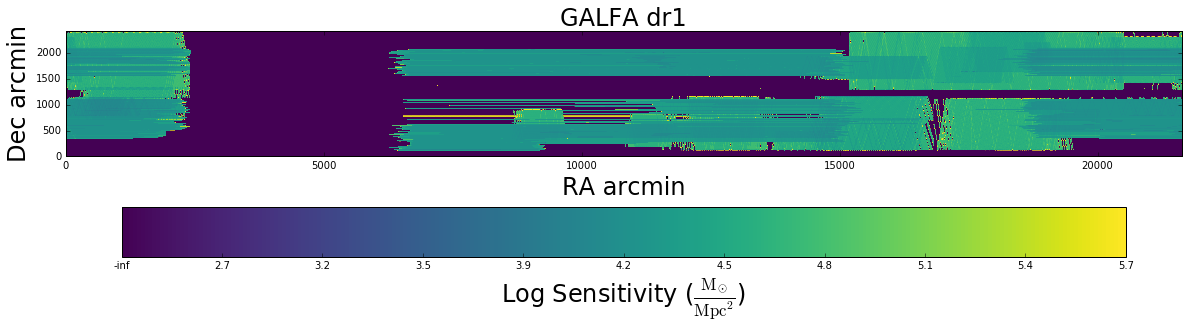

In [12]:
show_sens(galfa_sens, 'GALFA dr1')

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


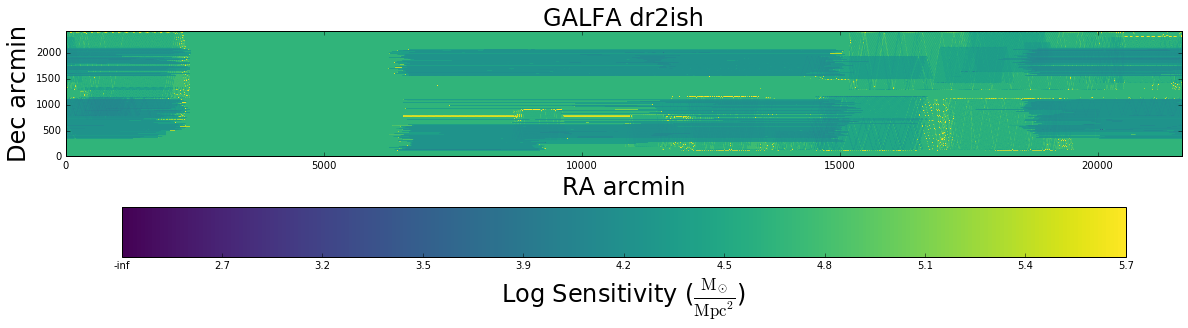

In [13]:
galfa_sens2 = galfa_sens.copy()
galfa_sens2[galfa_sens==0] = 45000*galfa_sens.unit
show_sens(galfa_sens2, 'GALFA dr2ish')

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


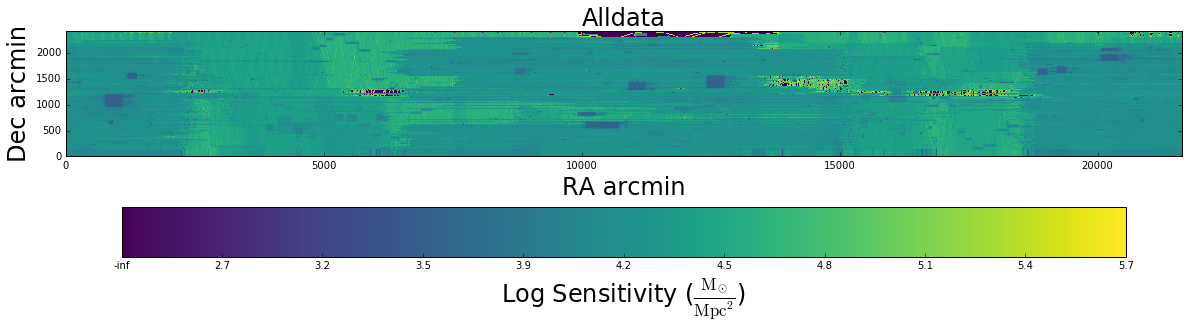

In [14]:
show_sens(galfa_sensall, 'Alldata')

# Simulate a GALFA-like survey assuming ELVii are like the LG

## First we produce $M_{HI}$ for everything following Bradford+15

In [15]:
def bradford_15_mstar_to_mgas(mstar):
    logx = np.log10(mstar/u.Msun)
    faintmsk = logx < 8.6
    mgas = np.empty_like(logx)
    mgas[faintmsk] = 1.052 *logx[faintmsk] + 0.236
    mgas[~faintmsk] = 0.461 *logx[~faintmsk] + 5.329
    return u.solMass*10**mgas

In [16]:
# produce HI masses for each table
for tab in elvii_pairs.values():
    Ms = tab['Mstar_preferred']
    tab['MHI'] = bradford_15_mstar_to_mgas(Ms)

## Now we populate the tables with equatorial/ICRS coordinates as though these pairs were the real LG

In [17]:
for tab in elvii_pairs.values():
    #these add host{n}_lat/host{n}_lon/host{n}_dist
    data_loaders.add_oriented_radecs(tab, 0, 1, target_coord=m31)
    data_loaders.add_oriented_radecs(tab, 1, 0, target_coord=m31)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


## Then find what the sensitivity would be for a GALFA-like survey from each host in this pair, and if it's detectable

In [18]:
def compute_detectability(sens_arr, sens_wcs, scs, MHIs):
    """
    Returns (nearest_sensitivity, in_survey, detectable), all arrays
    """
    pxs = scs.to_pixel(sens_wcs)
    xp = np.round(pxs[0]).astype(int)
    yp = np.round(pxs[1]).astype(int)
    msk = (0<=xp)&(xp<sens_arr.shape[0])&(0<=yp)&(yp<sens_arr.shape[1])

    sens = np.zeros(len(scs), dtype=sens_arr.dtype)*sens_arr.unit
    sens[msk] = sens_arr[xp[msk], yp[msk]]
    sens[sens==0] = np.inf

    # test detectability
    det = sens * scs.distance**2 < MHIs
    
    return sens, np.isfinite(sens), det

def compute_elvis_detectability(sens_arr, sens_wcs, surveyname, elvii_pairs=elvii_pairs):
    for tab in elvii_pairs.values():
        for i in (0, 1):
            host_sc = SkyCoord(ra=tab['host{}_lon'.format(i)], 
                               dec=tab['host{}_lat'.format(i)],
                               distance=tab['host{}_dist'.format(i)])
            detres = compute_detectability(sens_arr, sens_wcs, host_sc, tab['MHI'])

            # now fill in table columns
            tab['closest_sens_{}_host{}'.format(surveyname, i)] = detres[0]
            tab['in_survey_{}_host{}'.format(surveyname, i)] = detres[1]
            tab['detectable_{}_host{}'.format(surveyname, i)] = detres[2]

In [19]:
# actually *do* the calculation from above
compute_elvis_detectability(galfa_sens, galfa_sens_wcs, 'dr1')
compute_elvis_detectability(galfa_sens2, galfa_sens_wcs, 'dr2')
compute_elvis_detectability(galfa_sensall, galfa_sensall_wcs, 'alldata')

### Also create some possible extensions of surveys, and compute detectability for them

### 100 sq degrees at 4000 $M_\odot$ sensitivity, *randomly* placed

In [20]:
npix = 100*60*60
galfa_sens_100sqdeg_random = galfa_sens.copy()

In [21]:
w1, w2 = np.where(galfa_sens_100sqdeg_random>0)
toup = np.random.permutation(len(w1))[:npix]
galfa_sens_100sqdeg_random[(w1[toup], w2[toup])] = 4000*u.Msun*u.Mpc**-2

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


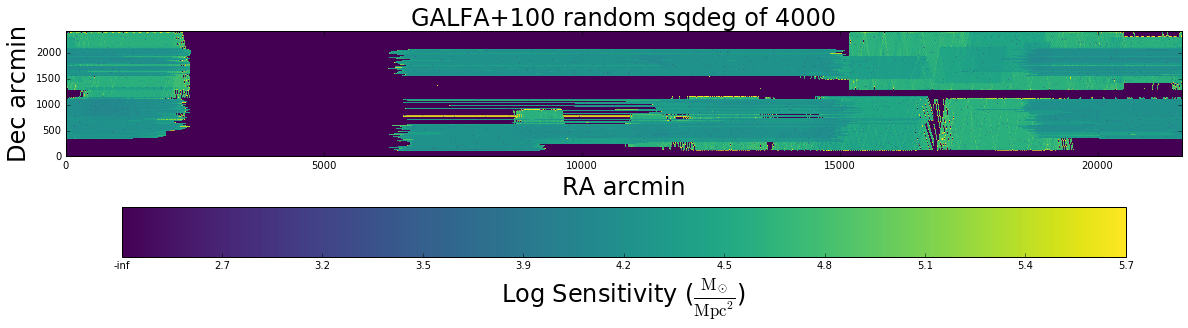

In [22]:
show_sens(galfa_sens_100sqdeg_random, 'GALFA+100 random sqdeg of 4000')

In [23]:
compute_elvis_detectability(galfa_sens_100sqdeg_random, galfa_sens_wcs, '100sqdeg_random')

### 1000 sq degrees at 12000 $M_\odot$ sensitivity, *randomly* placed

In [24]:
npix = 1000*60*60
galfa_sens_1000sqdeg_random = galfa_sens.copy()

In [25]:
w1, w2 = np.where(galfa_sens_1000sqdeg_random>0)
toup = np.random.permutation(len(w1))[:npix]
galfa_sens_1000sqdeg_random[(w1[toup], w2[toup])] = 12000*u.Msun*u.Mpc**-2

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


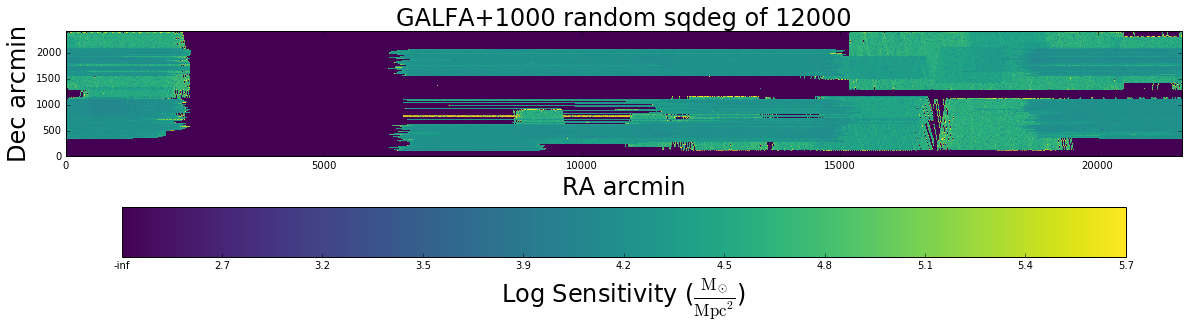

In [26]:
show_sens(galfa_sens_1000sqdeg_random, 'GALFA+1000 random sqdeg of 12000')

In [27]:
compute_elvis_detectability(galfa_sens_1000sqdeg_random, galfa_sens_wcs, '1000sqdeg_random')

### 100 sq degrees at 4000 $M_\odot$ sensitivity, *near target/M31*

In [28]:
npix = 100*60*60
galfa_sens_100sqdeg_near = galfa_sens.copy()

In [29]:
w1, w2 = np.where(galfa_sens_100sqdeg_near>0)

targetx, targety = m31.to_pixel(galfa_sens_wcs)

xg, yg = np.indices(galfa_sens_100sqdeg_near.shape)
dxyg = np.hypot(xg - targetx, yg - targety)
toup = np.argsort(dxyg[w1, w2])[:npix]

galfa_sens_100sqdeg_near[(w1[toup], w2[toup])] = 4000*u.Msun*u.Mpc**-2

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


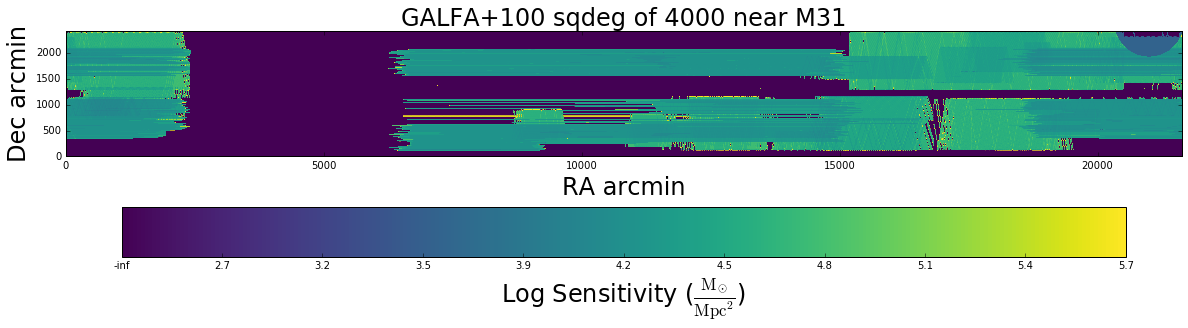

In [30]:
show_sens(galfa_sens_100sqdeg_near, 'GALFA+100 sqdeg of 4000 near M31')

In [31]:
compute_elvis_detectability(galfa_sens_100sqdeg_near, galfa_sens_wcs, '100sqdeg_near')

### 1000 sq degrees at 12000 $M_\odot$ sensitivity, *near target/M31*

In [32]:
npix = 1000*60*60
galfa_sens_1000sqdeg_near = galfa_sens.copy()

In [33]:
w1, w2 = np.where(galfa_sens_1000sqdeg_near>0)

targetx, targety = m31.to_pixel(galfa_sens_wcs)

xg, yg = np.indices(galfa_sens_1000sqdeg_near.shape)
dxyg = np.hypot(xg - targetx, yg - targety)
toup = np.argsort(dxyg[w1, w2])[:npix]

galfa_sens_1000sqdeg_near[(w1[toup], w2[toup])] = 12000*u.Msun*u.Mpc**-2

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


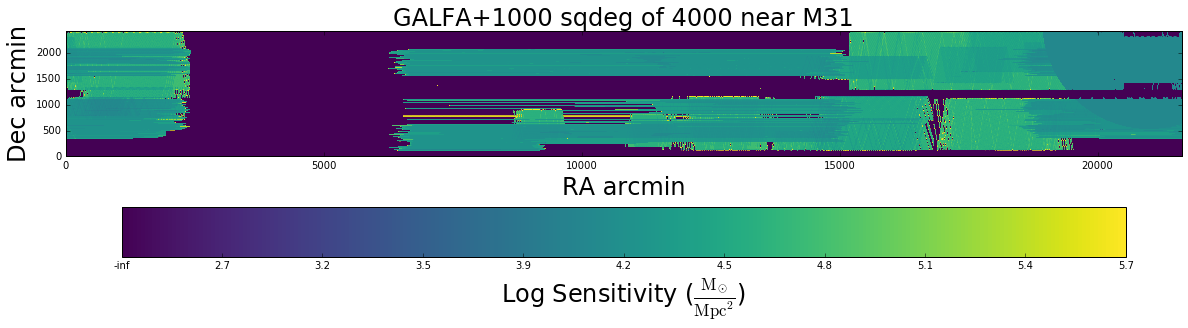

In [34]:
show_sens(galfa_sens_1000sqdeg_near, 'GALFA+1000 sqdeg of 4000 near M31')

In [35]:
compute_elvis_detectability(galfa_sens_1000sqdeg_near, galfa_sens_wcs, '1000sqdeg_near')

## Now check if   velocity is far enough from MW

In [36]:
# this is from Yong Zheng
from find_vlsr_minmax_allsky import find_vlsr_minmax # accepts degrees l,b

_vect_find_vlsr_minmax = np.vectorize(find_vlsr_minmax)
def vlsr_minmax_wrapped(sc):
    scgal = sc.galactic
    return np.array(_vect_find_vlsr_minmax(scgal.l.degree, scgal.b.degree))

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


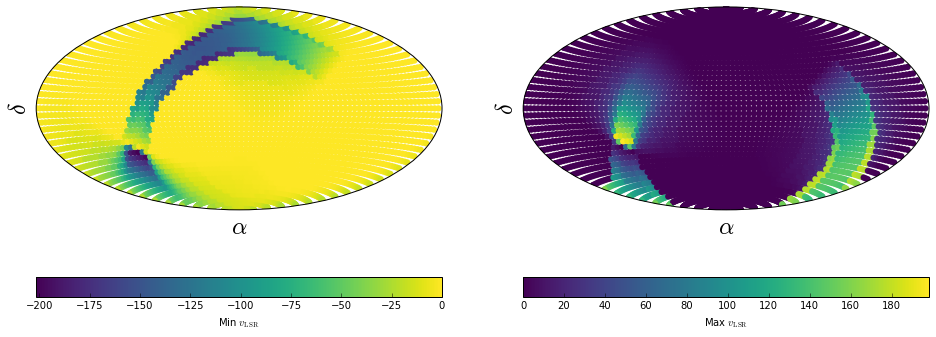

In [37]:
# check that the Vdev derived makes sense
scgrid = SkyCoord(*np.meshgrid(np.linspace(-180, 180, 90), np.linspace(-90, 90, 45))*u.deg)
vlsrmin, vlsrmax = vlsr_minmax_wrapped(scgrid)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1, projection = 'hammer')
plt.scatter(scgrid.ra.wrap_at(180*u.deg).rad, scgrid.dec.rad, c=vlsrmin, lw=0,s=40, alpha=1)
#plt.title('ICRS')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\alpha$',fontsize=24)
plt.ylabel(r'$\delta$',fontsize=24)
plt.colorbar(orientation='horizontal').set_label(r'Min $v_{\rm LSR}$')

plt.subplot(1,2,2, projection = 'hammer')
plt.scatter(scgrid.ra.wrap_at(180*u.deg).rad, scgrid.dec.rad, c=vlsrmax, lw=0,s=40, alpha=1)
#plt.title('ICRS')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\alpha$',fontsize=24)
plt.ylabel(r'$\delta$',fontsize=24)
plt.colorbar(orientation='horizontal').set_label(r'Max $v_{\rm LSR}$')

In [38]:
for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        scs = SkyCoord(ra, dec)
        vdevmin, vdevmax = vlsr_minmax_wrapped(scs)*u.km/u.s
        vlsr = tab['host{}_vrlsr'.format(i)]
        tab['host{}_vdevok'.format(i)] = vdevok = (vlsr>vdevmax)|(vdevmin>vlsr)
        print('Host',name.split('&')[i], 'frac vdev ok=',np.sum(vdevok)/len(vdevok), 'of', len(scs))

Host Zeus frac vdev ok= 0.964014191586 of 3946
Host Hera frac vdev ok= 0.953117080588 of 3946
Host Hamilton frac vdev ok= 0.959098786828 of 2885
Host Burr frac vdev ok= 0.942114384749 of 2885
Host Thelma frac vdev ok= 0.955699940933 of 1693
Host Louise frac vdev ok= 0.904311872416 of 1693
Host Romulus frac vdev ok= 0.951740506329 of 2528
Host Remus frac vdev ok= 0.916139240506 of 2528
Host Orion frac vdev ok= 0.975831873905 of 2855
Host Taurus frac vdev ok= 0.912434325744 of 2855
Host Kek frac vdev ok= 0.968506212077 of 3461
Host Kauket frac vdev ok= 0.933545218145 of 3461
Host Lincoln frac vdev ok= 0.943591574438 of 2801
Host Douglas frac vdev ok= 0.927168868261 of 2801
Host Serena frac vdev ok= 0.967889908257 of 4796
Host Venus frac vdev ok= 0.903461217681 of 4796
Host Scylla frac vdev ok= 0.936043855642 of 4378
Host Charybdis frac vdev ok= 0.921653723161 of 4378
Host Sonny frac vdev ok= 0.936681222707 of 2290
Host Cher frac vdev ok= 0.910480349345 of 2290
Host Hall frac vdev ok= 0.9

## And check if  velocity is far enough from MW HVCs

In [39]:
wakker_hvcs = table.Table.read('wakk.fits')
wakker_hvcs.show_in_notebook(display_length=1)

In [40]:
wakk_scs = SkyCoord(l=wakker_hvcs['L']*u.deg, b=wakker_hvcs['B']*u.deg, frame='galactic')
wakk_scs1 = SkyCoord(l=wakker_hvcs['L'].reshape(len(wakker_hvcs), 1)*u.deg, 
                     b=wakker_hvcs['B'].reshape(len(wakker_hvcs), 1)*u.deg, 
                     frame='galactic')

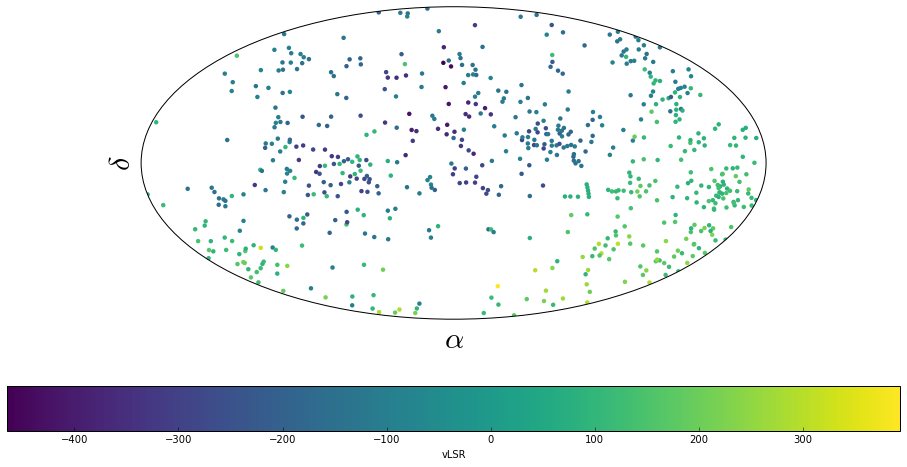

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(projection = 'hammer')
plt.scatter(wakk_scs.icrs.ra.wrap_at(180*u.deg).rad, wakk_scs.icrs.dec.rad, c=wakker_hvcs['VLSR'], lw=0)
#plt.title('ICRS')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\alpha$',fontsize=30)
plt.ylabel(r'$\delta$',fontsize=30)
plt.colorbar(orientation='horizontal').set_label('vLSR')

In [42]:
D_threshold = 25

for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        scs = SkyCoord(ra, dec)
        
        seps = scs.separation(wakk_scs1) # this is now len(wakk) x len(tab)
        dv = tab['host{}_vrlsr'.format(i)] - wakker_hvcs['VLSR'].reshape(len(wakker_hvcs), 1)*(u.km/u.s)
        dHVCs_all = np.sqrt(seps.deg**2 + (dv.to('km/s').value/2.)**2)
        
        tab['host{}_dHVC'.format(i)] = dHVCs = np.min(dHVCs_all, axis=0)
        tab['host{}_dHVCok'.format(i)] = dHVCs > D_threshold
        print('Host',name.split('&')[i], 'frac dHVC ok=',np.sum(dHVCs > 25)/len(dHVCs), 'of', len(scs))

Host Zeus frac dHVC ok= 0.271414090218 of 3946
Host Hera frac dHVC ok= 0.271414090218 of 3946
Host Hamilton frac dHVC ok= 0.224956672444 of 2885
Host Burr frac dHVC ok= 0.294627383016 of 2885
Host Thelma frac dHVC ok= 0.246308328411 of 1693
Host Louise frac dHVC ok= 0.236857649144 of 1693
Host Romulus frac dHVC ok= 0.270965189873 of 2528
Host Remus frac dHVC ok= 0.256329113924 of 2528
Host Orion frac dHVC ok= 0.198598949212 of 2855
Host Taurus frac dHVC ok= 0.313485113835 of 2855
Host Kek frac dHVC ok= 0.20109794857 of 3461
Host Kauket frac dHVC ok= 0.267841664259 of 3461
Host Lincoln frac dHVC ok= 0.265619421635 of 2801
Host Douglas frac dHVC ok= 0.27740092824 of 2801
Host Serena frac dHVC ok= 0.266680567139 of 4796
Host Venus frac dHVC ok= 0.364053377815 of 4796
Host Scylla frac dHVC ok= 0.259479214253 of 4378
Host Charybdis frac dHVC ok= 0.228414801279 of 4378
Host Sonny frac dHVC ok= 0.26768558952 of 2290
Host Cher frac dHVC ok= 0.294759825328 of 2290
Host Hall frac dHVC ok= 0.2731

## Consider "findeable" to be all three

In [43]:
for name, tab in elvii_pairs.items():
    for nm in tab.colnames:
        if nm.startswith('detectable'):
            suffix = nm[10:]
            det = tab[nm]
            vdevOK = tab['host'+nm[-1] + '_vdevok']
            dHVCok = tab['host'+nm[-1] + '_dHVCok']
            tab['findable' + suffix] = det & vdevOK & dHVCok

## Also record which are subs of the hosts

In [44]:
for name, tab in elvii_pairs.items():
    id0, id1 = tab['ID'][:2]
    tab['sat_of_0'] = tab['UpID'] == id0
    tab['sat_of_1'] = tab['UpID'] == id1
    tab['sat_of_either'] = tab['sat_of_0']|tab['sat_of_1']

# Summary figures 

## Findable objects: 

In [45]:
def compute_summaries(detname, makehists=True, **histkwargs):
    findables = []
    dets = []
    nonsatfindables = []

    for name, tab in elvii_pairs.items():
        for i in (0, 1):
            det = tab['detectable_{}_host{}'.format(detname, i)]
            findable = tab['findable_{}_host{}'.format(detname, i)]
            sats = tab['sat_of_either']

            findables.append(np.sum(findable))
            dets.append(np.sum(det))
            nonsatfindables.append(np.sum(findable&~sats))
            
    findables, dets, nonsatfindables = np.array((findables, dets, nonsatfindables))
    if makehists:
        plt.subplot(1, 3, 1)
        ahist(findables, histtype='step',**histkwargs)
        plt.xlabel('N findable')

        plt.subplot(1, 3, 2)
        ahist(findables/dets, histtype='step',**histkwargs)
        plt.xlabel('frac findable (of detectable)')

        plt.subplot(1, 3, 3)
        ahist(nonsatfindables, histtype='step',**histkwargs)
        plt.xlabel('N findable also not sat')
        
    return {'name': detname, 'findable': findables, 'detectable': dets, 'findable not sat':nonsatfindables}

In [46]:
summaries = []

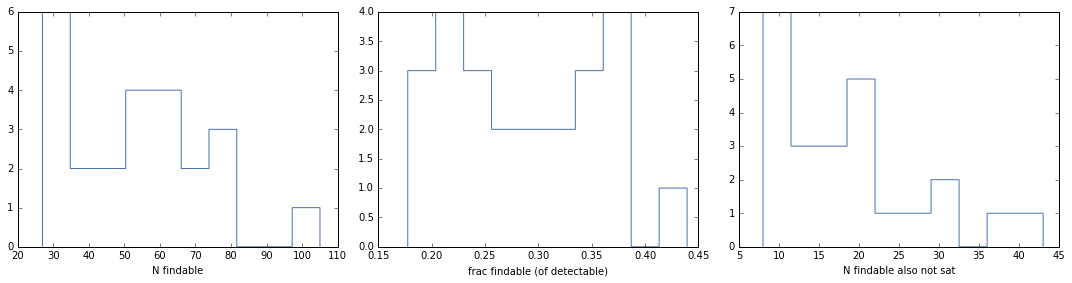

In [47]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('dr1'))
plt.tight_layout()

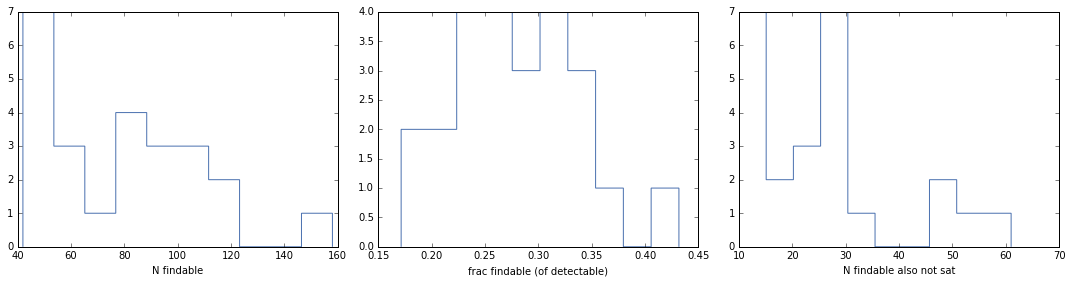

In [48]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('dr2'))
plt.tight_layout()

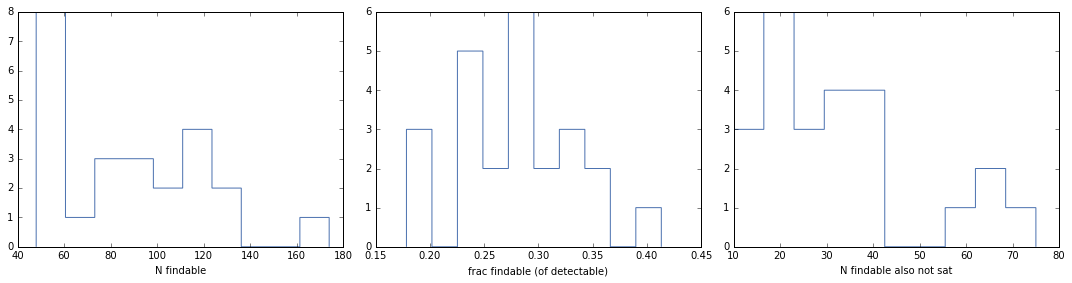

In [49]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('alldata'))
plt.tight_layout()

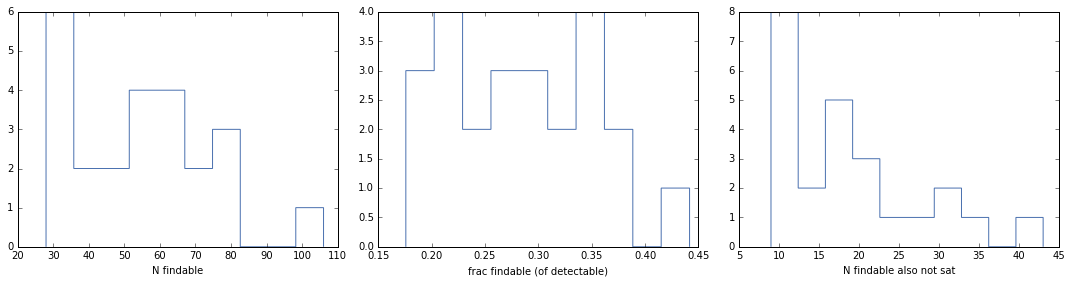

In [50]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('100sqdeg_random'))
plt.tight_layout()

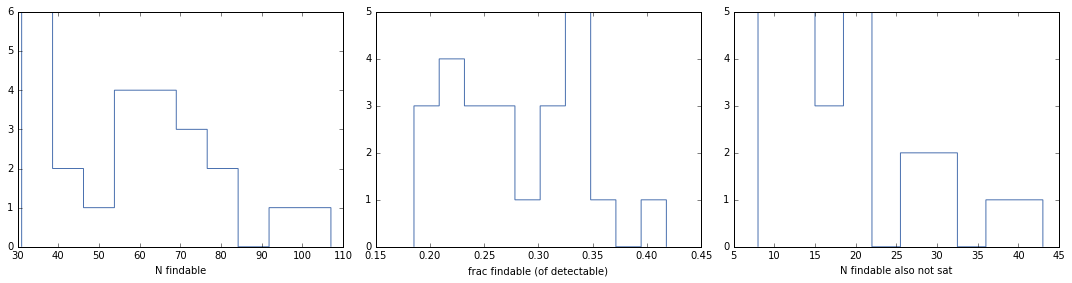

In [51]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('100sqdeg_near'))
plt.tight_layout()

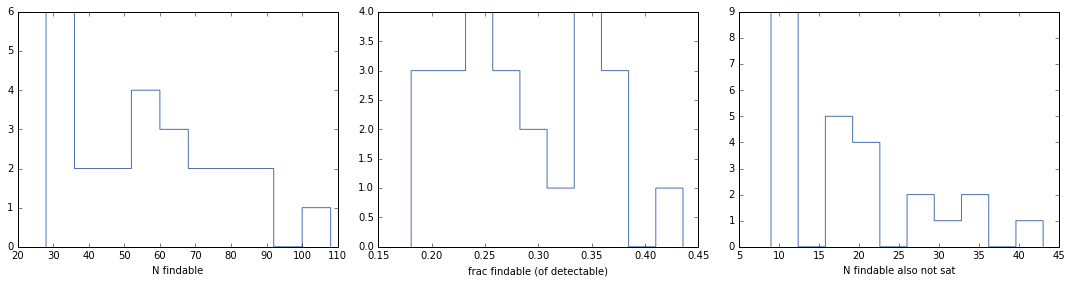

In [52]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('1000sqdeg_random'))
plt.tight_layout()

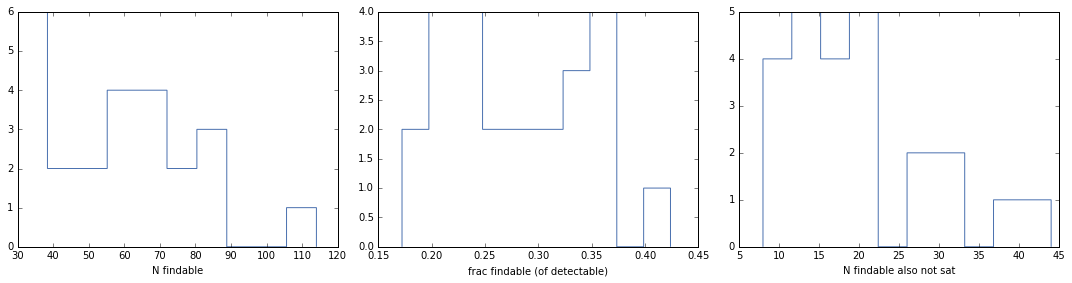

In [53]:
plt.figure(figsize=(15, 4))
summaries.append(compute_summaries('1000sqdeg_near'))
plt.tight_layout()

### All in one 

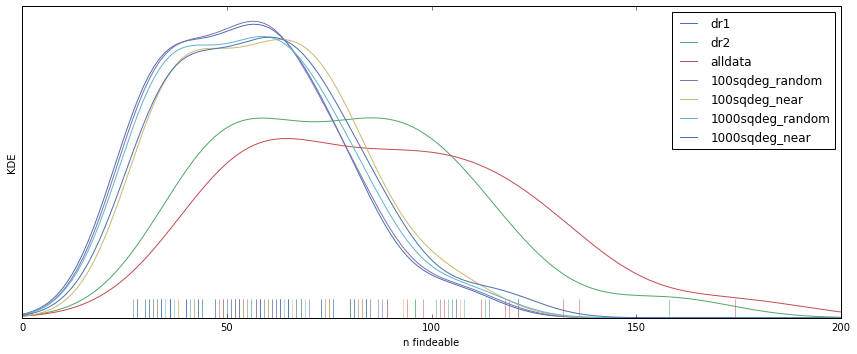

In [54]:
x = np.linspace(0,200, 150)
ymax = 0

plt.figure(figsize=(12,5))

for summ in summaries:
    data = summ['findable']
    
    kde = gaussian_kde(data, 'scott')
    pline = plt.plot(x, kde(x), label=summ['name'])[0]
    if np.max(kde(x)) > ymax:
        ymax = np.max(kde(x))
    plt.vlines(data, 0, 0.06, transform=plt.gca().get_xaxis_transform(), color=pline.get_color(), alpha=.5)

    plt.legend(loc=0)

plt.xlabel('n findeable')
plt.ylabel('KDE')
plt.yticks([])
plt.ylim(0,ymax*1.05)
plt.xlim(x[0], x[-1])
plt.tight_layout()

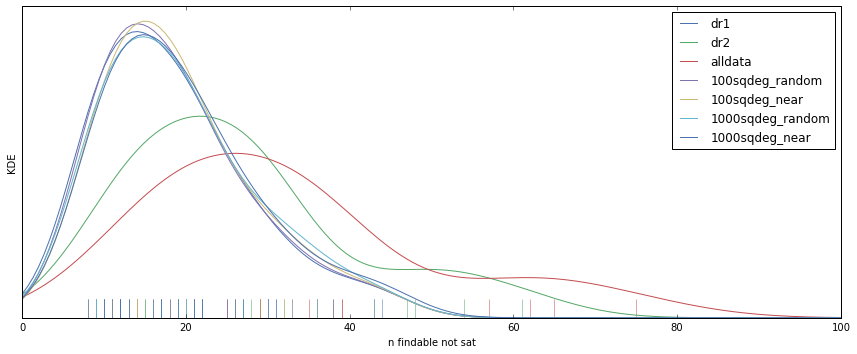

In [55]:
x = np.linspace(0, 100, 150)
ymax = 0

plt.figure(figsize=(12,5))

for summ in summaries:
    data = summ['findable not sat']
    
    kde = gaussian_kde(data, 'scott')
    pline = plt.plot(x, kde(x), label=summ['name'])[0]
    if np.max(kde(x)) > ymax:
        ymax = np.max(kde(x))
    plt.vlines(data, 0, 0.06, transform=plt.gca().get_xaxis_transform(), color=pline.get_color(), alpha=.5)

    plt.legend(loc=0)

plt.xlabel('n findable not sat')
plt.ylabel('KDE')
plt.yticks([])
plt.ylim(0,ymax*1.05)
plt.xlim(x[0], x[-1])
plt.tight_layout()

# Velocity histograms 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


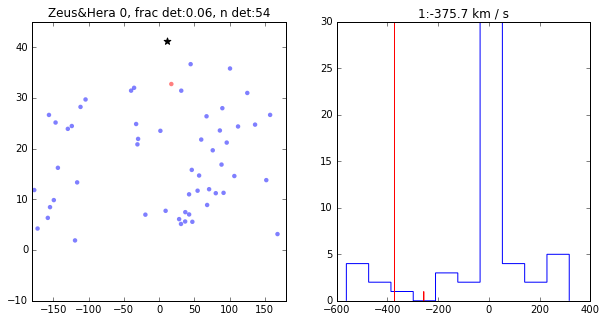

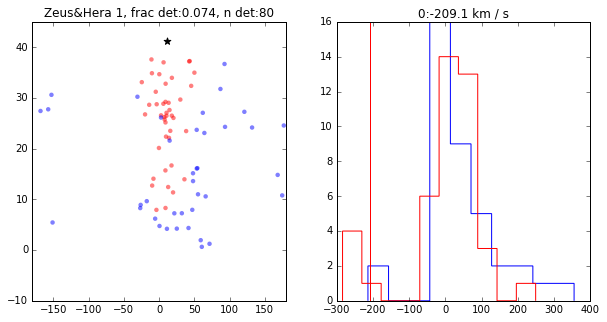

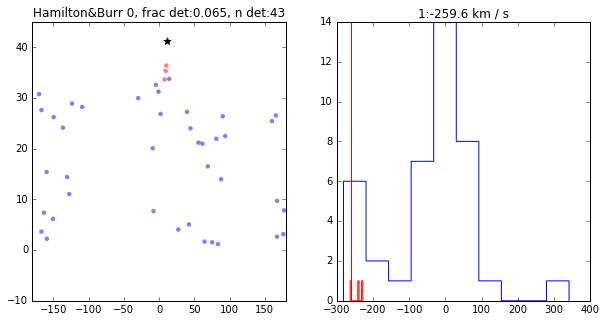

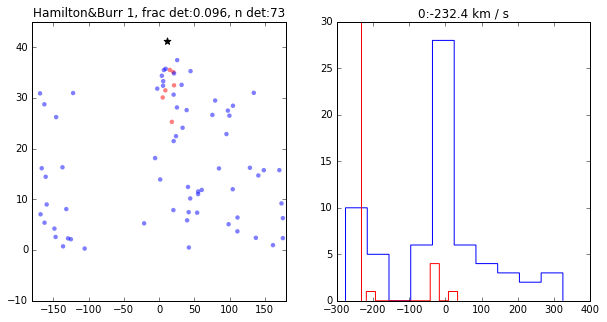

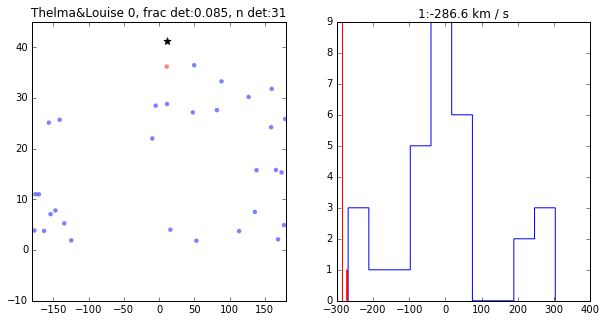

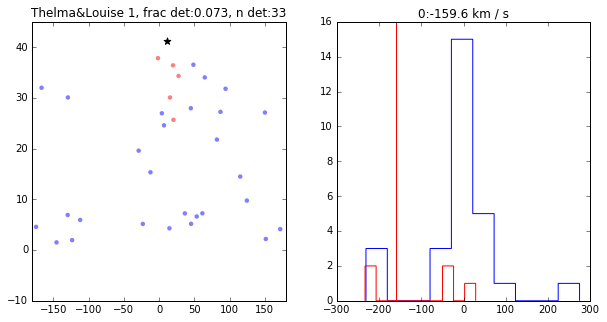

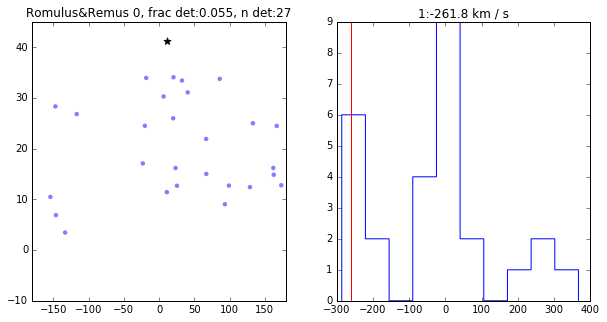

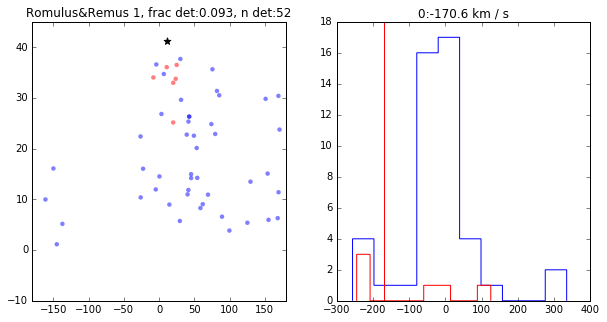

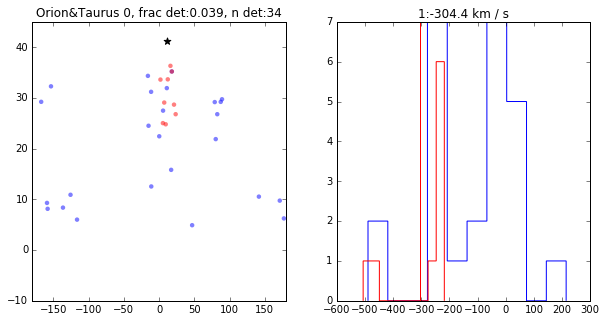

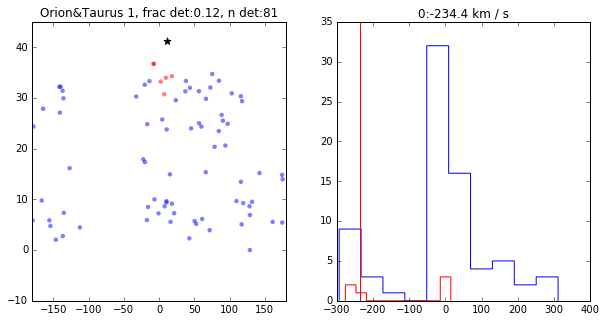

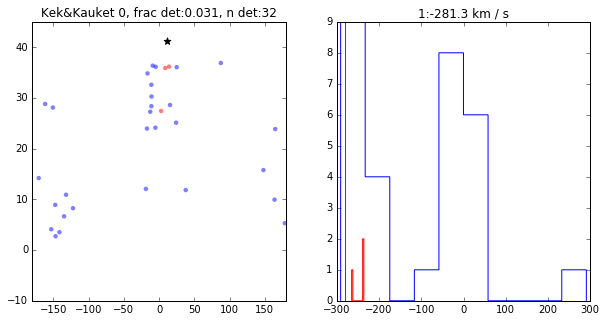

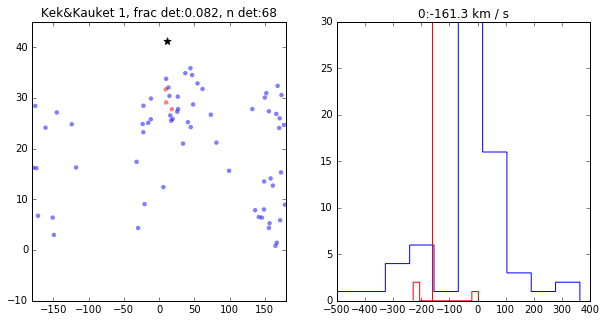

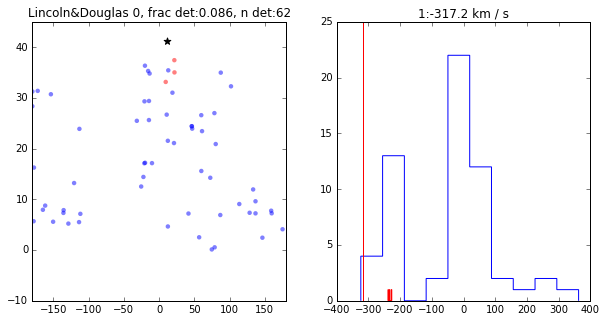

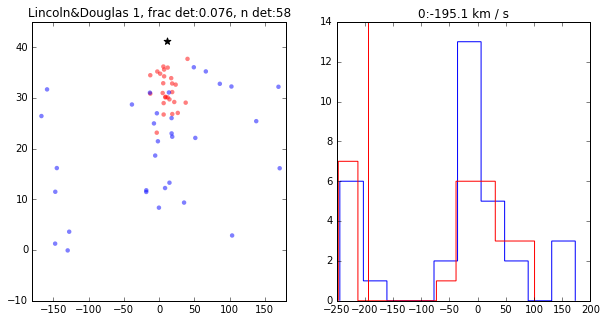

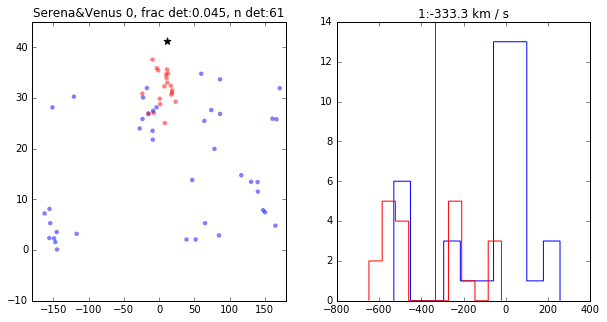

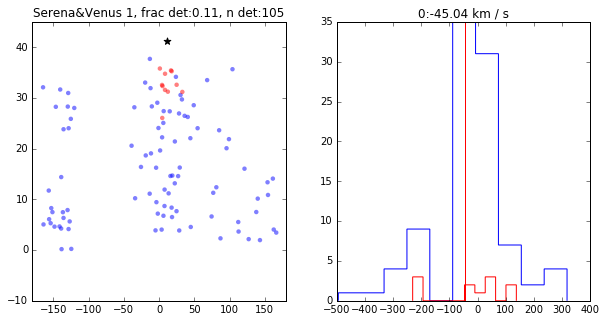

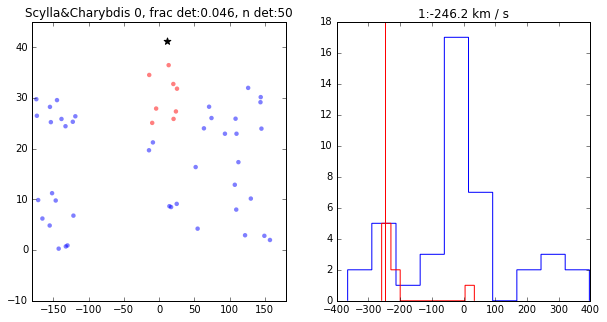

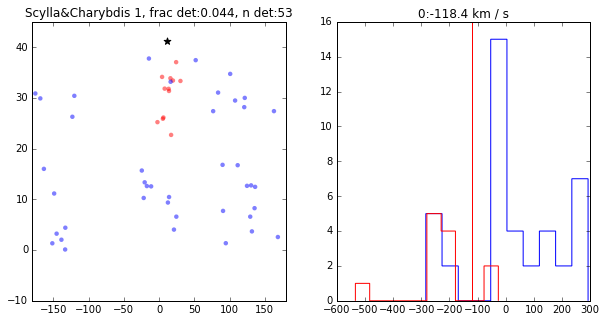

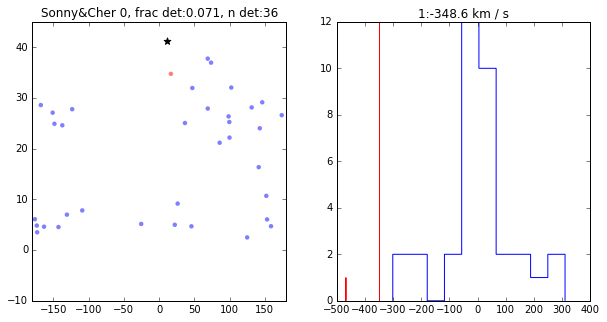

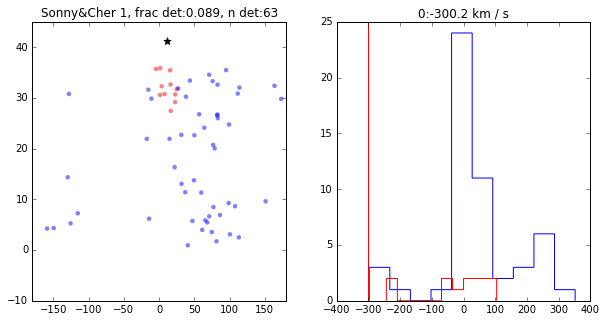

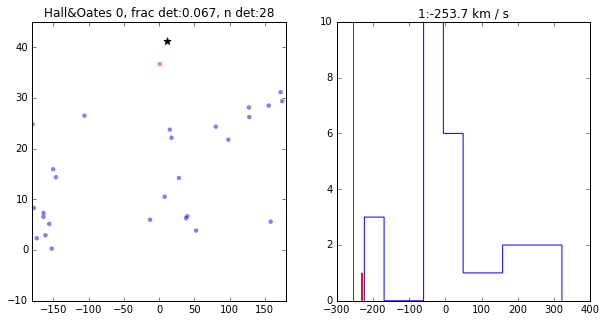

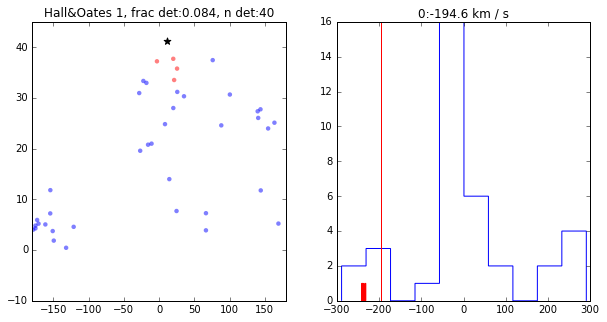

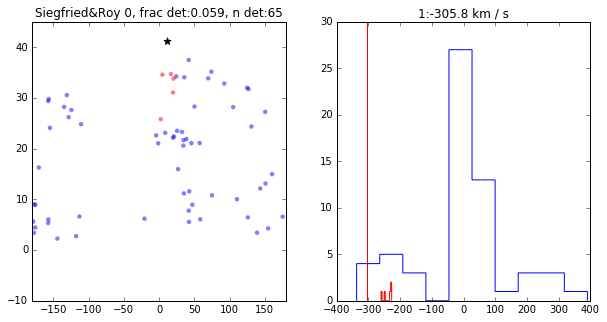

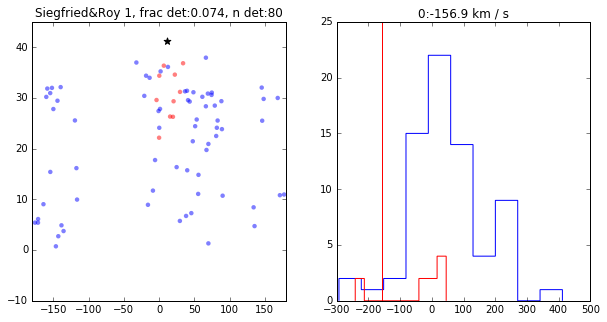

In [56]:
det_survey_name = 'dr1'

for name, tab in elvii_pairs.items():
    for i in (0, 1):
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]
        insurv = tab['in_survey_{}_host{}'.format(det_survey_name, i)]
        det = tab['findable_{}_host{}'.format(det_survey_name, i)]
        
        fracdet = np.sum(det)/np.sum(insurv)
        
        
        otheridx = 1 if i==0 else 0
        x, y, z = tab['X'], tab['Y'], tab['Z']
        dother = ((x-x[otheridx])**2+(y-y[otheridx])**2+(z-z[otheridx])**2)**0.5
        inrvir = dother < tab['Rvir'][otheridx]
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1,2, 1)
        plt.scatter(ra[det].wrap_at(180*u.deg).deg, dec[det].deg, c=inrvir[det],lw=0, alpha=.5, cmap='bwr')
        plt.scatter(ra[otheridx].wrap_at(180*u.deg).deg, dec[otheridx].deg, color='k', alpha=1, marker='*', s=50)
        plt.title('{} {}, frac det:{:.2}, n det:{}'.format(name, i, fracdet, np.sum(det)))
        plt.xlim(-180, 180)
        plt.ylim(-10, 45)
        
        plt.subplot(1,2, 2)
        vr = tab['host{}_vrlsr'.format(i)]
        plt.hist(vr[det&~inrvir].value, color='b', histtype='step')
        plt.hist(vr[det&inrvir].value, color='r', histtype='step')
        plt.axvline(vr[otheridx].value, c='r')
        plt.title('{}:{:.4}'.format(otheridx, vr[otheridx]))

## Separations of host/targets

In [57]:
for name, tab in elvii_pairs.items():
    dx = tab['X'][1] - tab['X'][0]
    dy = tab['Y'][1] - tab['Y'][0]
    dz = tab['Z'][1] - tab['Z'][0]
    d = (dx**2 + dy**2 + dz**2)**0.5
    
    dvx = tab['Vx'][1] - tab['Vx'][0]
    dvy = tab['Vy'][1] - tab['Vy'][0]
    dvz = tab['Vz'][1] - tab['Vz'][0]
    vsep = (dvx*dx + dvy*dy + dvz*dz)/d
    
    print(name , '{:.4}'.format(d.to(u.kpc)), '{:.4}'.format(vsep.to(u.km/u.s)))

Zeus&Hera 595.2 kpc -200.7 km / s
Hamilton&Burr 941.3 kpc -84.83 km / s
Thelma&Louise 832.2 kpc -111.5 km / s
Romulus&Remus 935.4 kpc -86.78 km / s
Orion&Taurus 829.3 kpc -128.7 km / s
Kek&Kauket 1.04e+03 kpc -106.1 km / s
Lincoln&Douglas 780.4 kpc -142.0 km / s
Serena&Venus 687.4 kpc -157.8 km / s
Scylla&Charybdis 705.1 kpc -71.16 km / s
Sonny&Cher 966.2 kpc -173.5 km / s
Hall&Oates 979.5 kpc -78.48 km / s
Siegfried&Roy 877.6 kpc -130.8 km / s


## On-sky maps of targets

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


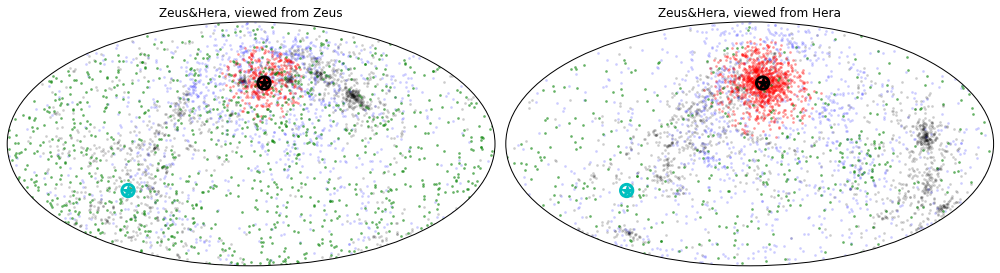

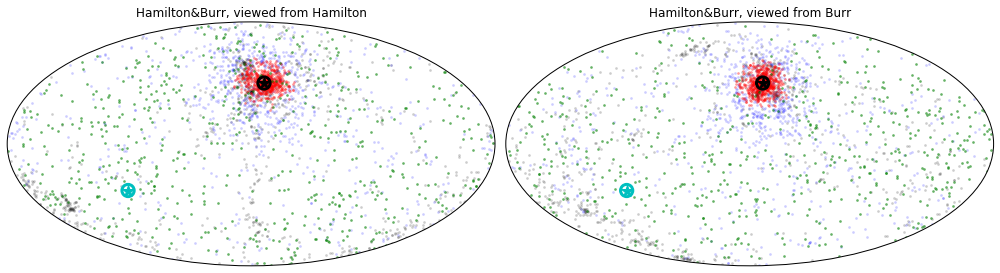

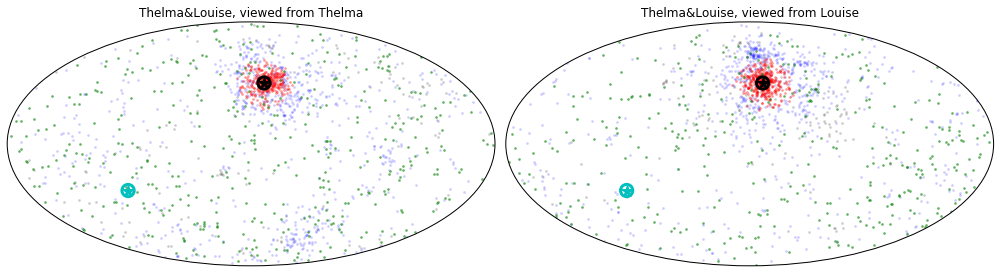

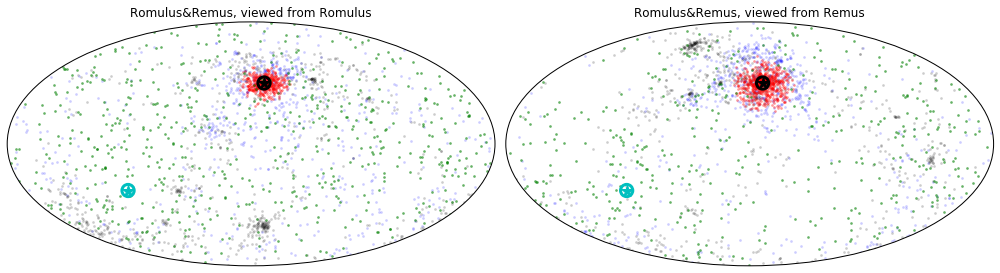

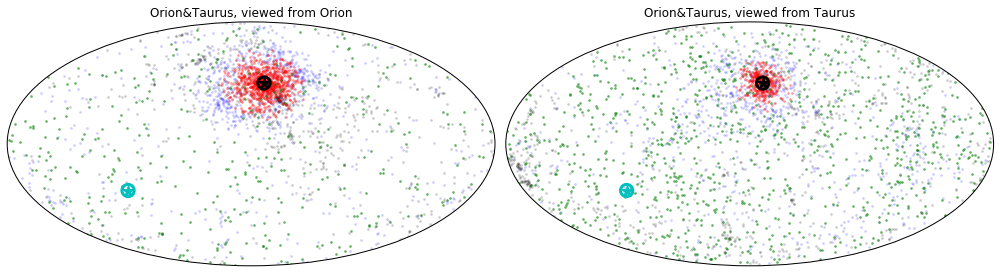

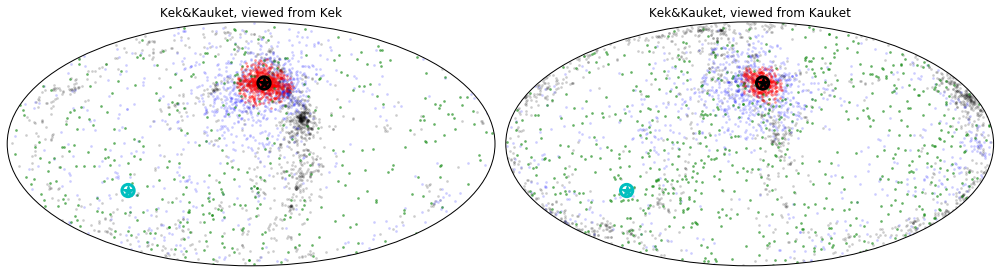

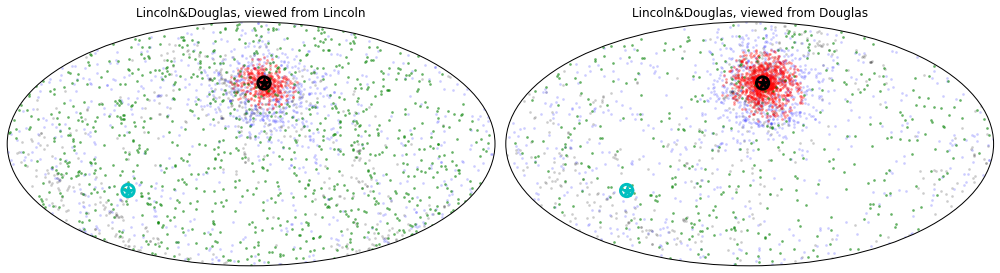

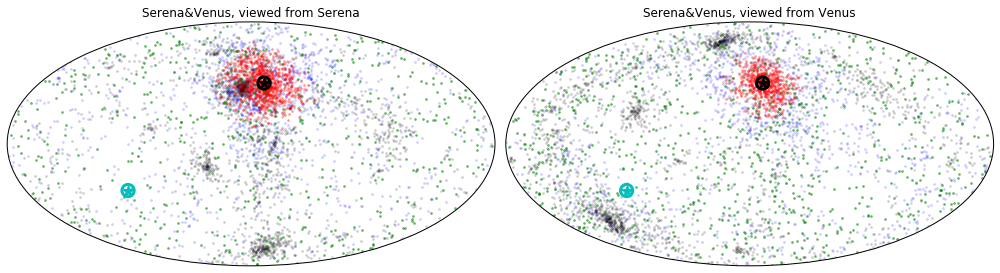

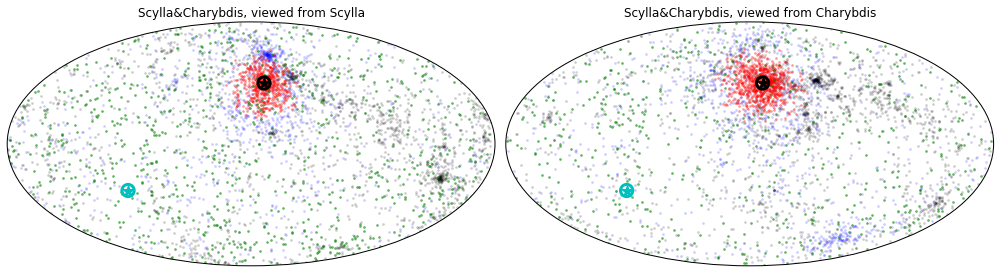

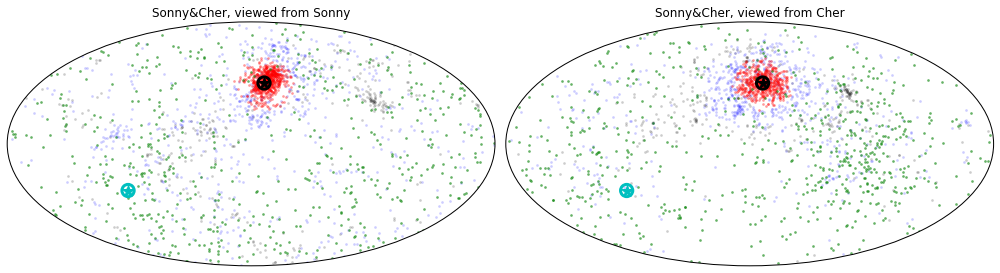

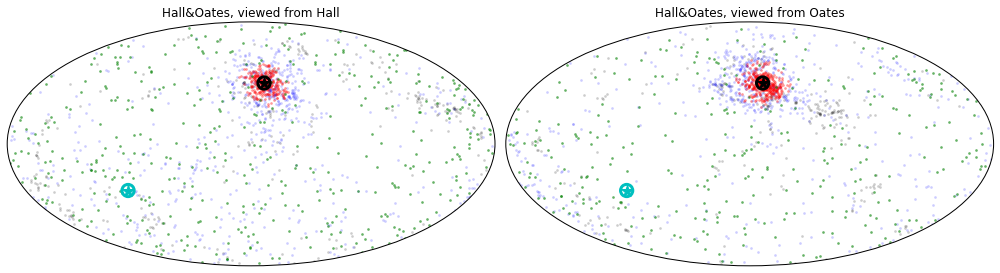

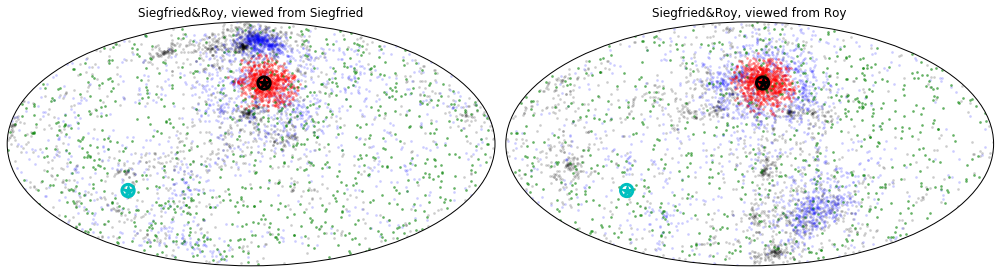

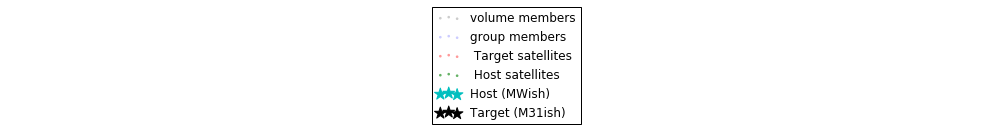

In [58]:
for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        hostidx = i
        otheridx = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))

        ax = plt.subplot(1,2,i+1, projection='hammer')

        #the plot information and plots of actual subs
        sats = [tab['sat_of_0'], tab['sat_of_1']]
        nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)
        msk0 = ~(sats[hostidx]|sats[otheridx]|nearboth)
        msk2 = sats[otheridx]
        msk3 = sats[hostidx]
        msk1 = ~(msk0|msk2|msk3)
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=7, alpha=.2, lw=0, label='volume members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='b',s=7, alpha=.2, lw=0, label='group members')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='r',s=7, alpha=.4, lw=0, label=' Target satellites')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=7, alpha=.6, lw=0, label=' Host satellites')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheridx]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


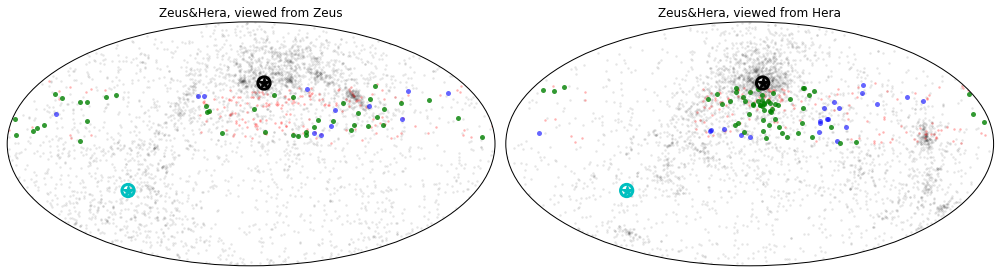

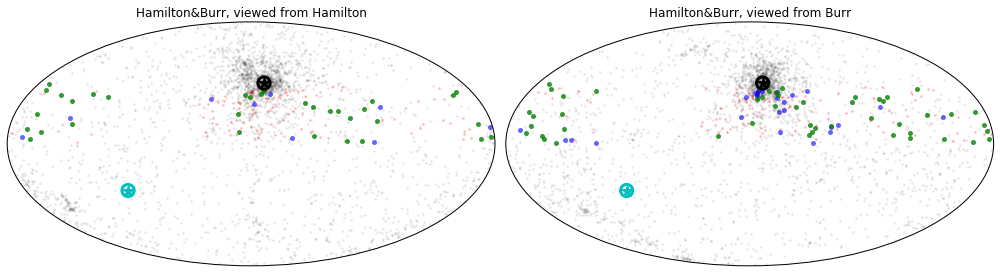

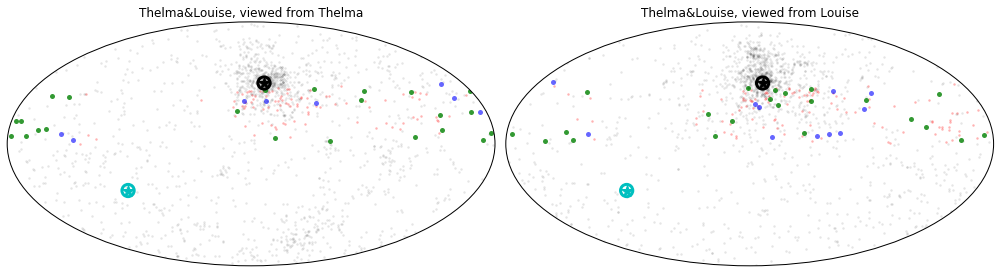

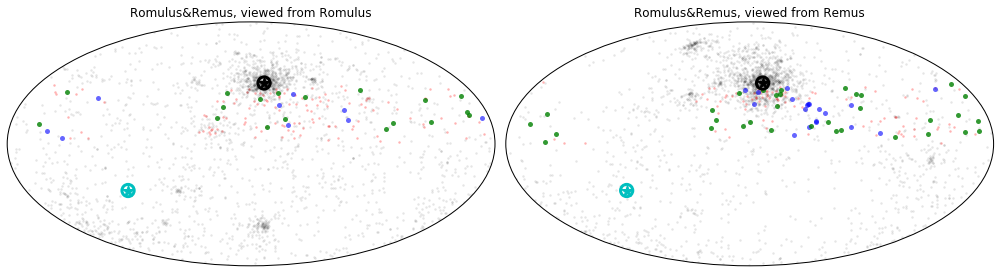

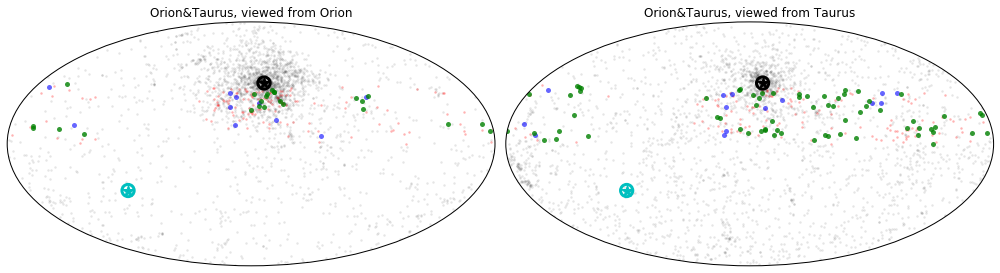

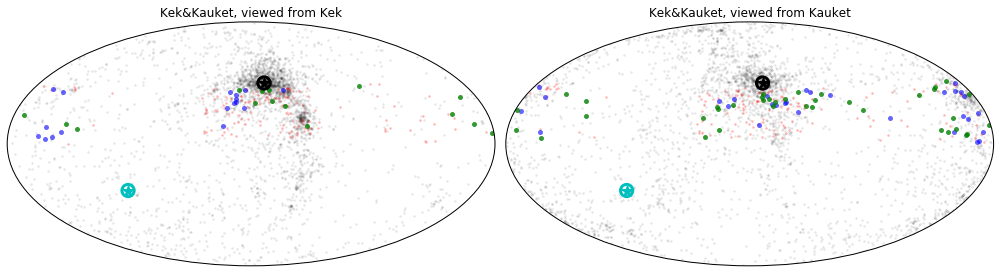

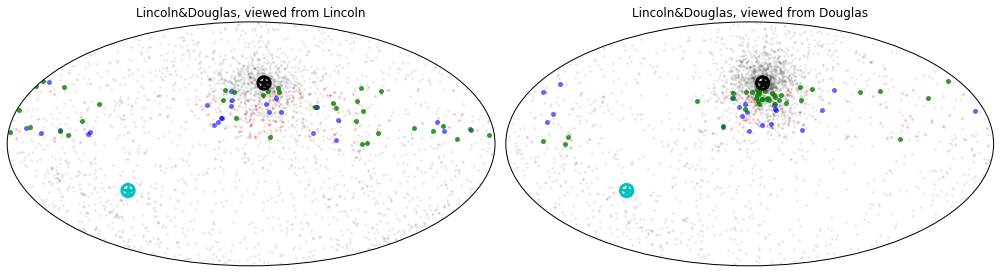

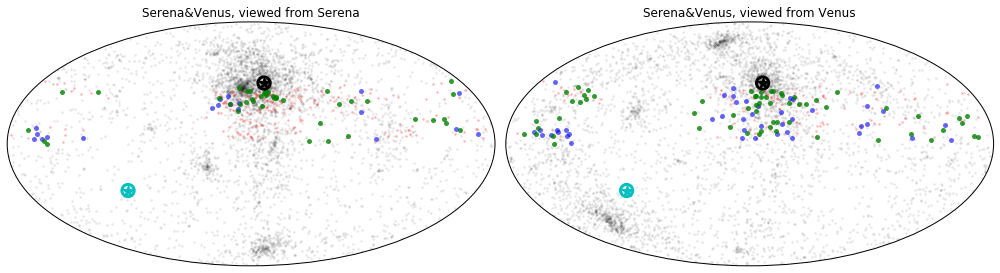

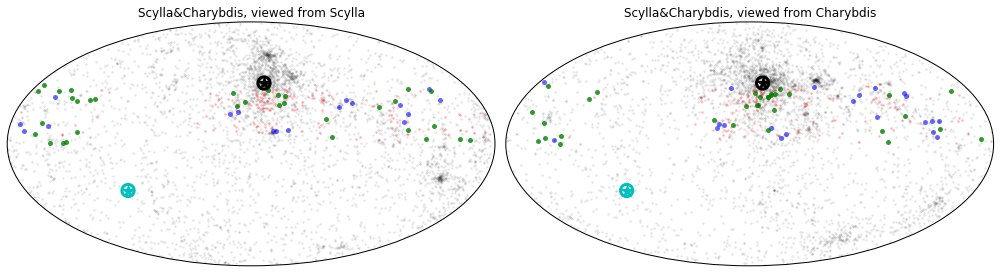

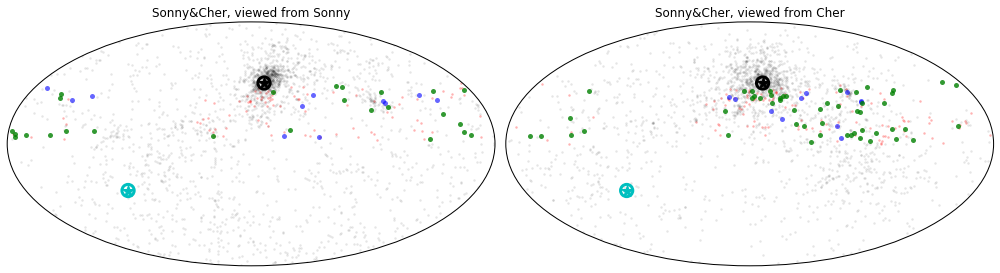

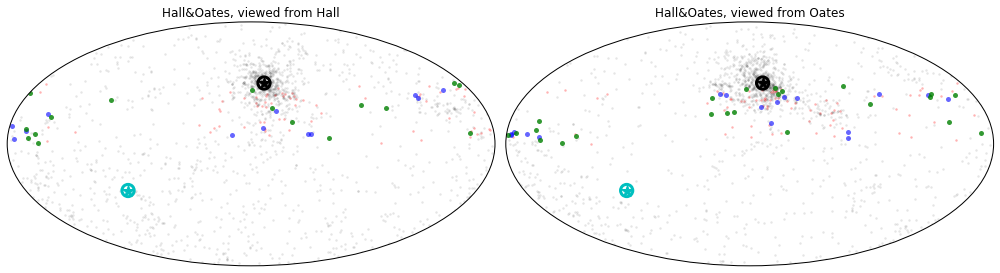

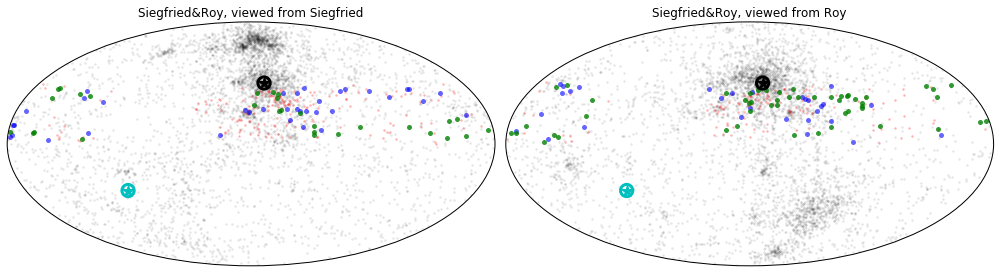

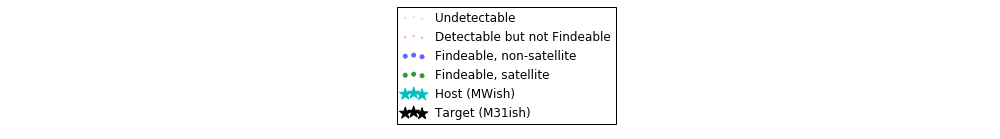

In [59]:
det_survey_name = 'dr1'

for names, tab in elvii_pairs.items():
    hnames = names.split('&')
    
    plt.figure(figsize=(14,10))
    for i in (0, 1):
        hostidx = i
        otheridx = 1 if i==0 else 0
        
        ra = tab['host{}_lon'.format(i)]
        dec = tab['host{}_lat'.format(i)]

        scs = []
        scs.append(SkyCoord(tab['host0_lon'],tab['host0_lat'],distance=tab['host0_dist']))
        scs.append(SkyCoord(tab['host1_lon'],tab['host1_lat'],distance=tab['host1_dist']))

        ax = plt.subplot(1,2,i+1, projection='hammer')

        #the plot information and plots of actual subs
        det = tab['detectable_{}_host{}'.format(det_survey_name, hostidx)]
        find = tab['findable_{}_host{}'.format(det_survey_name, hostidx)]
        msk0 = ~det
        msk1 = det&~find
        msk2 = find&~tab['sat_of_either']
        msk3 = find&tab['sat_of_either']
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk0]), c='k',s=6, alpha=.1, lw=0, label='Undetectable')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk1]), c='r',s=6, alpha=.3, lw=0, label='Detectable but not Findeable')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk2]), c='b',s=25, alpha=.6, lw=0, label='Findeable, non-satellite')
        ax.scatter(*coo_to_scatter_inputs(scs[i][msk3]), c='g',s=25, alpha=.8, lw=0, label='Findeable, satellite')

        ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150, label='Host (MWish)')
        ax.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150, label='Target (M31ish)')


        ax.scatter(*coo_to_scatter_inputs(scs[i][i]), edgecolors='c', marker='o', s=150, lw=3, c='none')
        ax.scatter(*coo_to_scatter_inputs(scs[i][otheridx]), edgecolors='k', marker='o', s=150, lw=3, c='none')

        plt.xticks([])
        plt.yticks([])
        plt.title('{}, viewed from {}'.format(names, hnames[i]))
        plt.tight_layout()
        
        leghand, leglabels = ax.get_legend_handles_labels()

lfig = plt.figure(figsize=(14,2))
lax = plt.subplot()
lax.axis('off')
leg = plt.legend(leghand, leglabels,loc='center')
plt.tight_layout()

# 3D plots for a selected host

In [60]:
# for interactive 3D plot
# %matplotlib nbagg

In [61]:
hostname = 'Roy'
det_survey_name = 'dr1'  #definition of "detectable"

In [62]:
dobreak = False
for tname, tab in elvii_pairs.items():
    names = tname.split('&')
    for i, name in enumerate(names):
        if name==hostname:
            #tab already set
            othername = names[0] if i else names[1]
            hostidx = i
            otheridx = 1 if i==0 else 0
            dobreak = True
    if dobreak:
        break
else:
    del tab, hostidx
    raise ValueError('Could not find host ' + hostname)
    
axlims = [(-1.5, 1.5)]*3

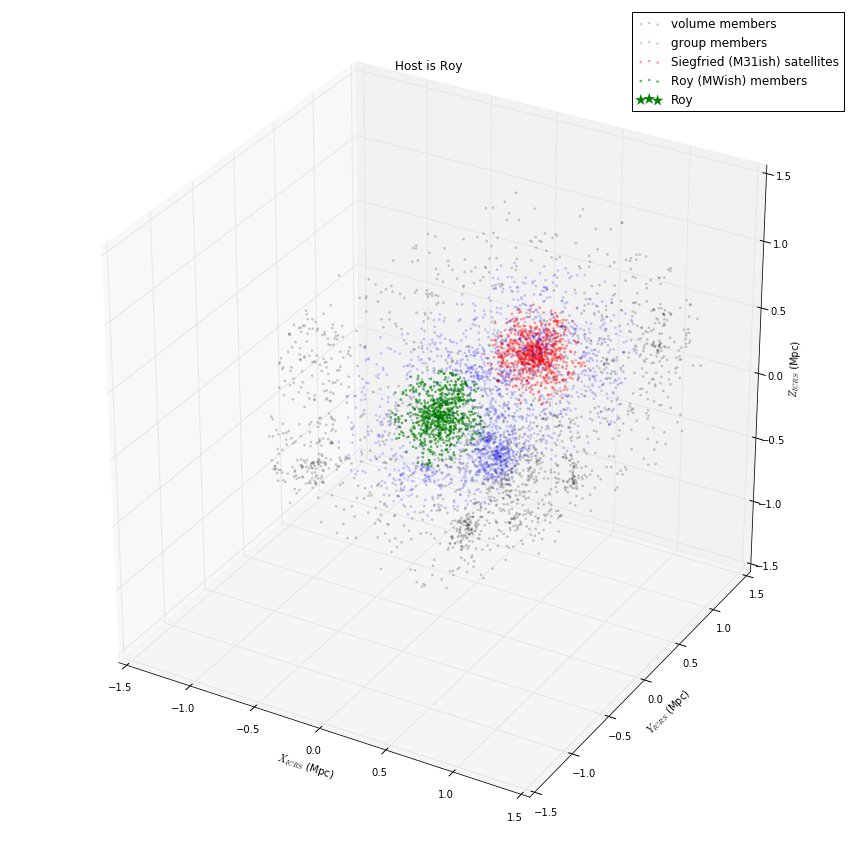

In [63]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

sats = [tab['sat_of_0'], tab['sat_of_1']]
nearboth = (tab['host0_dist']<.7*u.Mpc)|(tab['host1_dist']<.7*u.Mpc)


plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~(sats[hostidx]|sats[otheridx]|nearboth)
msk2 = sats[otheridx]
msk3 = sats[hostidx]
msk1 = ~(msk0|msk2|msk3)

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=7, alpha=.2, lw=0, label='volume members')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='b',s=7, alpha=.2, lw=0, label='group members')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='r',s=7, alpha=.4, lw=0, label=othername + ' (M31ish) satellites')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=7, alpha=.6, lw=0, label=hostname + ' (MWish) members')
ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)


ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

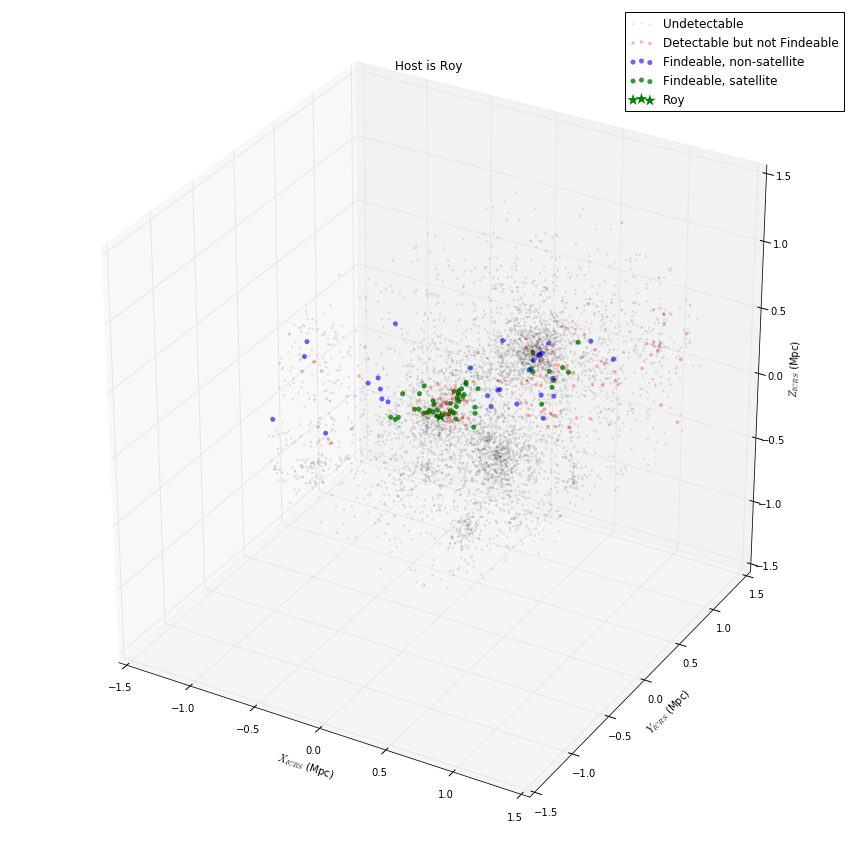

In [64]:
hoststr = 'host' + str(hostidx)
sc = SkyCoord(tab[hoststr+'_lon'],tab[hoststr+'_lat'],distance=tab[hoststr+'_dist'])
dx, dy, dz = sc.cartesian.xyz.to(u.Mpc).value
# dx = tab['X']-tab['X'][hostidx]
# dy = tab['Y']-tab['Y'][hostidx]
# dz = tab['Z']-tab['Z'][hostidx]

det = tab['detectable_{}_host{}'.format(det_survey_name, hostidx)]
find = tab['findable_{}_host{}'.format(det_survey_name, hostidx)]

plt.figure(figsize=(12, 12))
ax = plt.subplot(projection='3d')

msk0 = ~det
msk1 = det&~find
msk2 = find&~tab['sat_of_either']
msk3 = find&tab['sat_of_either']

ax.scatter3D(dx[msk0], dy[msk0], dz[msk0], c='k',s=6, alpha=.1, lw=0, label='Undetectable')
ax.scatter3D(dx[msk1], dy[msk1], dz[msk1], c='r',s=12, alpha=.3, lw=0, label='Detectable but not Findeable')
ax.scatter3D(dx[msk2], dy[msk2], dz[msk2], c='b',s=25, alpha=.6, lw=0, label='Findeable, non-satellite')
ax.scatter3D(dx[msk3], dy[msk3], dz[msk3], c='g',s=25, alpha=.8, lw=0, label='Findeable, satellite')


ax.scatter3D([0], [0], [0], c='g', marker='*', s=150, label=hostname, lw=0)
plt.legend(loc=0)

ax.set_xlim3d(*axlims[0])
ax.set_ylim3d(*axlims[1])
ax.set_zlim3d(*axlims[2])
ax.set_xlabel('$X_{ICRS}$ (Mpc)')
ax.set_ylabel('$Y_{ICRS}$ (Mpc)')
ax.set_zlabel('$Z_{ICRS}$ (Mpc)')

plt.title('Host is '+hostname)
plt.tight_layout()

# Info about the findeable/not sat things 

In [65]:
survey = 'dr1'
findable_tabs = []
findable_notsat_tabs = []

for name, tab in elvii_pairs.items():
    f0 = tab['findable_{}_host0'.format(survey)]
    f1 = tab['findable_{}_host1'.format(survey)]
    findable_tabs.append(tab[f0])
    findable_tabs.append(tab[f1])
    
    findable_notsat_tabs.append(tab[f0&~tab['sat_of_0']])
    findable_notsat_tabs.append(tab[f1&~tab['sat_of_1']])

findables_tab = table.QTable(table.vstack([table.Table(t) for t in findable_tabs]))
findables_notsat_tab = table.QTable(table.vstack([table.Table(t) for t in findable_notsat_tabs]))

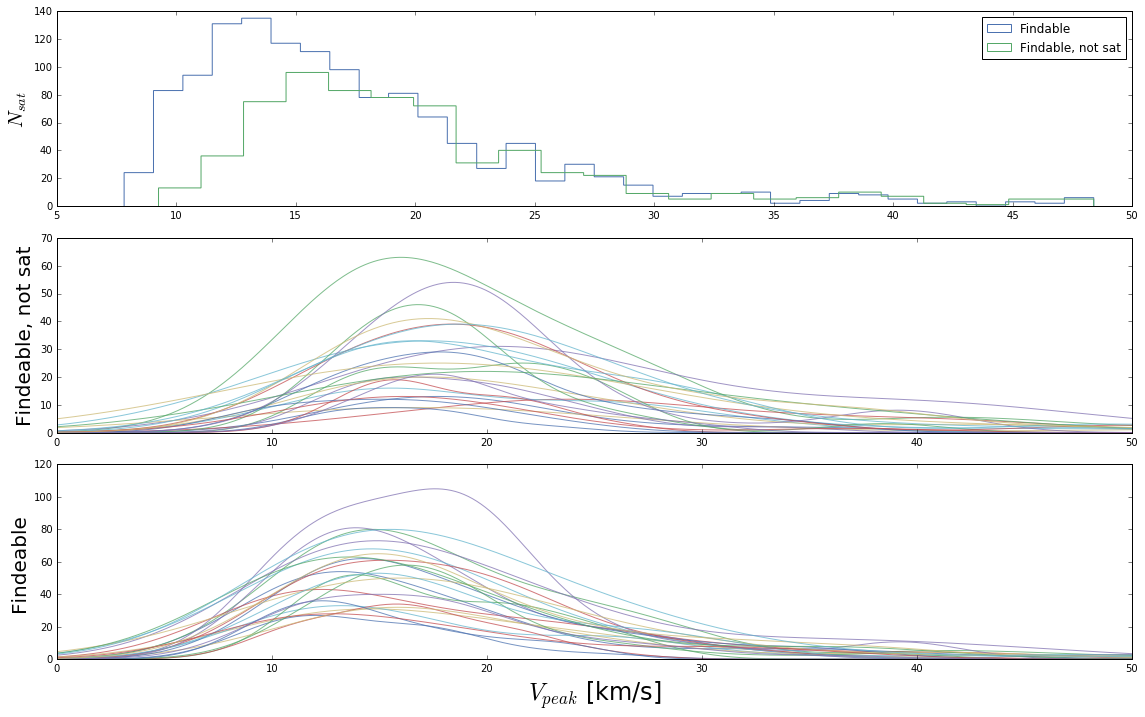

In [66]:
plt.figure(figsize=(16, 10))

plt.subplot(3,1,1)
ahist(findables_tab['Vpeak'].to(u.km/u.s), bins='knuth', histtype='step',range=(0,50), label='Findable')
ahist(findables_notsat_tab['Vpeak'].to(u.km/u.s), bins='knuth', histtype='step',range=(0,50), label='Findable, not sat')
plt.legend(loc=0)
plt.ylabel('$N_{sat}$',fontsize=20)


xs = np.linspace(0,50, 500)

plt.subplot(3,1,2)

for tab in findable_notsat_tabs:
    k = gaussian_kde(tab['Vpeak'].to(u.km/u.s).value, 'scott')
    plt.plot(xs, len(tab)*k(xs)/np.max(k(xs)), alpha=.75)
plt.ylabel('Findeable, not sat',fontsize=20)
    
    
plt.subplot(3,1,3)

for tab in findable_tabs:
    k = gaussian_kde(tab['Vpeak'].to(u.km/u.s).value, 'scott')
    plt.plot(xs, len(tab)*k(xs)/np.max(k(xs)), alpha=.75)
plt.ylabel('Findeable',fontsize=20)
    
plt.xlabel('$V_{peak}$ [km/s]', fontsize=24)
    
    
plt.tight_layout()

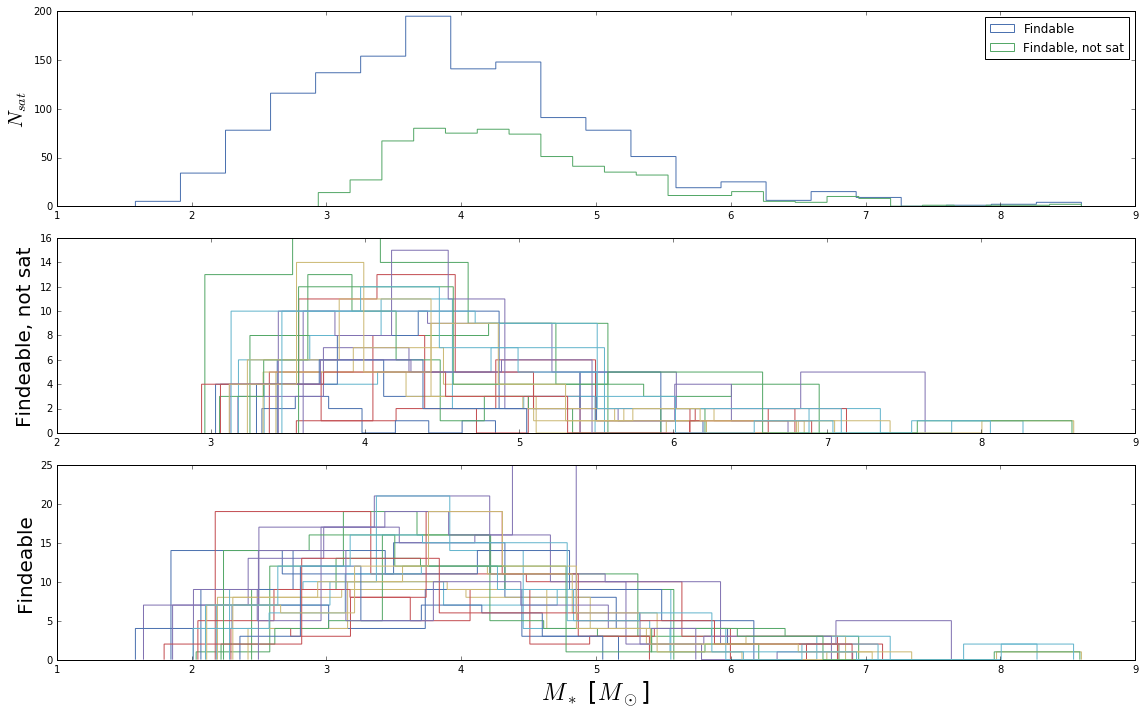

In [67]:
plt.figure(figsize=(16, 10))

plt.subplot(3,1,1)
ahist(np.log10(findables_tab['Mstar_preferred']/u.solMass), bins='knuth', histtype='step',range=(0,10), label='Findable')
ahist(np.log10(findables_notsat_tab['Mstar_preferred']/u.solMass), bins='knuth', histtype='step',range=(0,10), label='Findable, not sat')
plt.legend(loc=0)
plt.ylabel('$N_{sat}$',fontsize=20)


xs = np.linspace(0,10, 500)

plt.subplot(3,1,2)

for tab in findable_notsat_tabs:
#     k = gaussian_kde(np.log10(tab['Mstar_preferred']/u.solMass).value, 'scott')
#     plt.plot(xs, len(tab)*k(xs)/np.max(k(xs)), alpha=.75)
    ahist(np.log10(tab['Mstar_preferred']/u.solMass), bins='knuth', histtype='step',range=(0,10), label='Findable, not sat')
plt.ylabel('Findeable, not sat',fontsize=20)
    
    
plt.subplot(3,1,3)

for tab in findable_tabs:
    #k = gaussian_kde(np.log10(tab['Mstar_preferred']/u.solMass).value, 'scott')
    #plt.plot(xs, len(tab)*k(xs)/np.max(k(xs)), alpha=.75)
    ahist(np.log10(tab['Mstar_preferred']/u.solMass), bins='knuth', histtype='step',range=(0,10), label='Findable, not sat')

plt.ylabel('Findeable',fontsize=20)
    
plt.xlabel(r'$M_*$ [$M_\odot$]', fontsize=24)
    
    
plt.tight_layout()

# Check how many *real* LG objects are in the footprint 

In [68]:
import data_loaders

mcconn_tab = data_loaders.load_mccon12_table()

In [69]:
mcconMHI = mcconn_tab['MHI']*1e6*u.solMass
unk = mcconn_tab['MHI']==99.9
mcconMHI[unk] = -1*u.solMass

res_mcconn = compute_detectability(galfa_sens, galfa_sens_wcs, mcconn_tab['Coords'], mcconMHI)
mcconn_tab['nearest_sens'] = res_mcconn[0]
mcconn_tab['in_galfa'] = res_mcconn[1]
mcconn_tab['det_galfa'] = res_mcconn[2]

In [70]:
mcconn_tab[mcconn_tab['in_galfa']].show_in_notebook()

In [71]:
mcconn_tab[mcconn_tab['det_galfa']]['Name']

<Column name='Name' dtype='str18' length=3>
Sextans B
     GR 8
   KKH 86

See GALFA-knowndwarfs to see a more detailed investigation of these three

# Now ask how many things reionized

In [72]:
elvii_trees = data_loaders.load_elvii_trees('ID,Mvir,Vmax,Rvir,upID,scale')

Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hall&Oates
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Hamilton&Burr
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Kek&Kauket
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Lincoln&Douglas
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Orion&Taurus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Romulus&Remus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Scylla&Charybdis
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Serena&Venus
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Siegfried&Roy
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Sonny&Cher
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Thelma&Louise
Loading /Users/erik/projects/m31-galfa/elvis_data/PairedTrees/Zeus&Hera


/Users/erik/projects/m31-galfa/data_loaders.py:74: RuntimeWarning: divide by zero encountered in true_divide
  coldct['z'] = 1./coldct['scale'] - 1


In [73]:
for name, tree in elvii_trees.items():
    idxz7 = np.argmin(np.abs(tree[0]['z']-7))
    idxz8 = np.argmin(np.abs(tree[0]['z']-8))
    idxz9 = np.argmin(np.abs(tree[0]['z']-9))
    
    
    elvii_pairs[name]['Mviratz7'] = tree['Mvir'][:, idxz7]
    elvii_pairs[name]['Vmatz7'] = tree['Vmax'][:, idxz7]
    elvii_pairs[name]['Mviratz8'] = tree['Mvir'][:, idxz8]
    elvii_pairs[name]['Vmatz8'] = tree['Vmax'][:, idxz8]
    elvii_pairs[name]['Mviratz9'] = tree['Mvir'][:, idxz9]
    elvii_pairs[name]['Vmatz9'] = tree['Vmax'][:, idxz9]

## What cutoffs give exactly 3 

In [74]:
Mvircutoffs = []
Vmax_of_Mvircutoffs = []
Mstar_of_Mvircutoffs = []

Mstarcutoffs = []
MHIcutoffs = []

for name, tab in elvii_pairs.items():
    for i in range(2):
        findeable = tab['findable_dr1_host' + str(i)]
        notsat = ~tab['sat_of_either']
        mstarcut = tab['Mstar_preferred']>u.solMass*10**4
        
        findtab = tab[findeable&notsat]
        findtabwstar = tab[findeable&notsat&mstarcut]
        
        count_slc = slice(-4, -2) #3 and 4th most massive
        sorttab = findtabwstar[np.argsort(findtabwstar['Mviratz8'])]
        Mvircutoffs.append(sorttab['Mviratz8'][count_slc]) 
        Mstar_of_Mvircutoffs.append(sorttab['Mstar_preferred'][count_slc])
        Vmax_of_Mvircutoffs.append(sorttab['Vmatz8'][count_slc])
        
        Mstarcutoffs.append(np.sort(findtab['Mstar_preferred'])[count_slc])
        MHIcutoffs.append(np.sort(findtab['MHI'])[count_slc])

In [75]:
def get_bar_inputs(cutoffs, width=0.8, transform=lambda val:np.log10(val/u.solMass).value):
    counts = []
    heights = []
    bottoms = []

    i=0
    for cutoffs in cutoffs:
        i+=1
        if len(cutoffs) < 2 or np.any(cutoffs==0):
            pass
        else:
            counts.append(i)
            heights.append(np.ptp(transform(cutoffs)))
            bottoms.append(transform(cutoffs)[0])
            
    return np.array(counts)-width/2,heights,width,bottoms

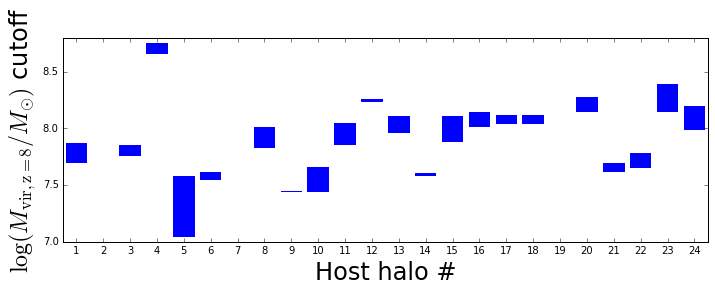

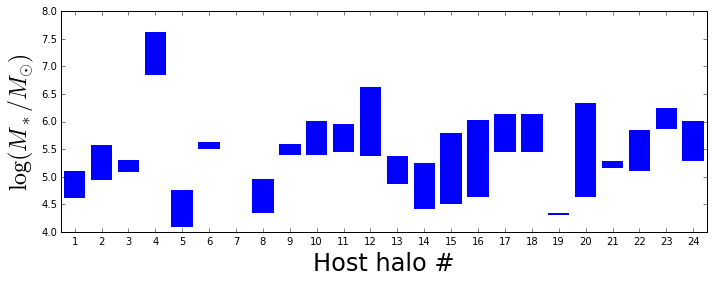

In [76]:
plt.figure(figsize=(10,4))
plt.bar(*get_bar_inputs(Mvircutoffs), lw=0)
plt.ylabel(r'$\log(M_{\rm vir,z=8}/M_{\odot})$ cutoff', fontsize=24)
plt.xlim(0.5,24.5)
plt.xticks(np.arange(24)+1)
plt.xlabel('Host halo #', fontsize=24)
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.bar(*get_bar_inputs(Mstar_of_Mvircutoffs), lw=0)
plt.ylabel(r'$\log(M_*/M_{\odot})$', fontsize=24)
plt.xlim(0.5,24.5)
plt.xticks(np.arange(24)+1)
plt.xlabel('Host halo #', fontsize=24)
plt.tight_layout()

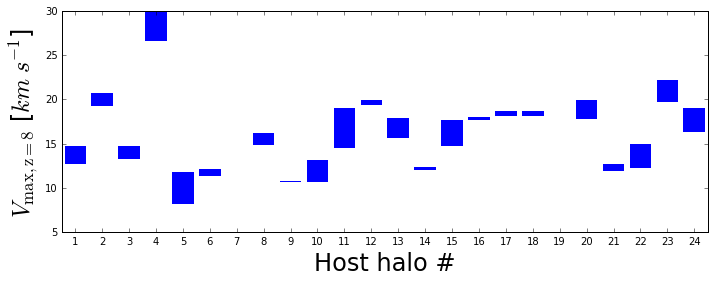

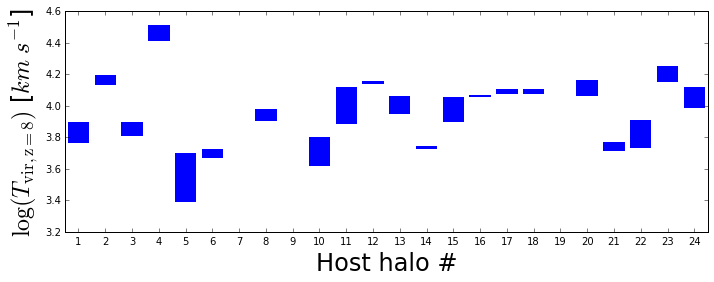

In [77]:
plt.figure(figsize=(10,4))
plt.bar(*get_bar_inputs(Vmax_of_Mvircutoffs, transform=lambda val:val.to('km/s').value), lw=0)
plt.ylabel(r'$V_{\rm max,z=8}$ [$km\;s^{-1}$]', fontsize=24)
plt.xlim(0.5,24.5)
plt.xticks(np.arange(24)+1)
plt.xlabel('Host halo #', fontsize=24)
plt.tight_layout()


plt.figure(figsize=(10,4))
vtotvir = lambda v: np.log10((0.6 * cnst.m_p*v**2 / 2 / cnst.k_B)/u.K)
plt.bar(*get_bar_inputs(Vmax_of_Mvircutoffs, transform=vtotvir), lw=0)
plt.ylabel(r'$\log(T_{\rm vir,z=8})$ [$km\;s^{-1}$]', fontsize=24)
plt.xlim(0.5,24.5)
plt.xticks(np.arange(24)+1)
plt.xlabel('Host halo #', fontsize=24)
plt.tight_layout()

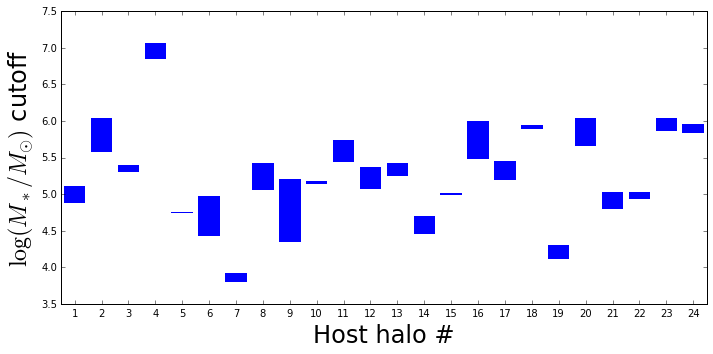

In [78]:
plt.figure(figsize=(10,5))
plt.bar(*get_bar_inputs(Mstarcutoffs), lw=0)
plt.xlabel('Host halo #', fontsize=24)
plt.ylabel(r'$\log(M_*/M_{\odot})$ cutoff', fontsize=24)

plt.xticks(np.arange(24)+1)
plt.xlim(0.5,24.5)

plt.tight_layout()

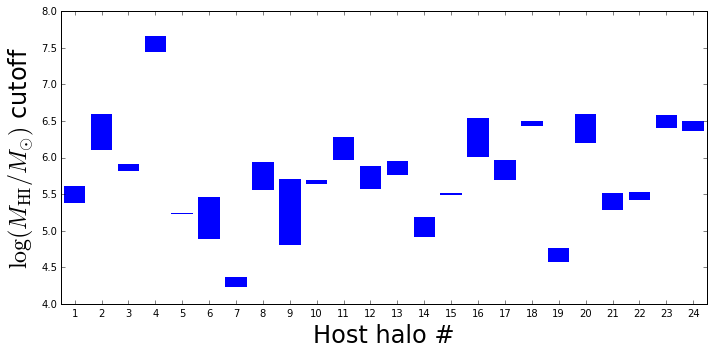

In [79]:
plt.figure(figsize=(10,5))
plt.bar(*get_bar_inputs(MHIcutoffs), lw=0)
plt.xlabel('Host halo #', fontsize=24)
plt.ylabel(r'$\log(M_{\rm HI}/M_{\odot})$ cutoff', fontsize=24)

plt.xticks(np.arange(24)+1)
plt.xlim(0.5,24.5)

plt.tight_layout()

# Better visualization of final counts 

In [80]:
raw_findable = []
nsat_findable = []
corr_findable = []

for name, tab in elvii_pairs.items():
    for i in range(2):
        find = tab['findable_dr1_host'+str(i)]
        nsat = ~tab['sat_of_either']
        mstarcut = tab['Mstar_preferred'] > u.solMass*10**4
        
        raw_findable.append(np.sum(find))
        nsat_findable.append(np.sum(find&nsat))
        corr_findable.append(np.sum(find&mstarcut&nsat))

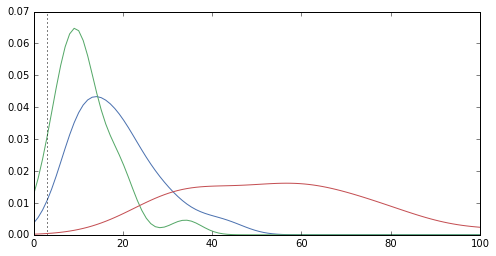

In [81]:
# KDE
x = np.linspace(0,100,100)
kr = gaussian_kde(raw_findable)
kn = gaussian_kde(nsat_findable)
kc = gaussian_kde(corr_findable)

plt.figure(figsize=(8,4))
plt.plot(x, kn(x))
plt.plot(x, kc(x))
plt.plot(x, kr(x))

plt.axvline(3, ls=':', c='k')

(0, 1.01)

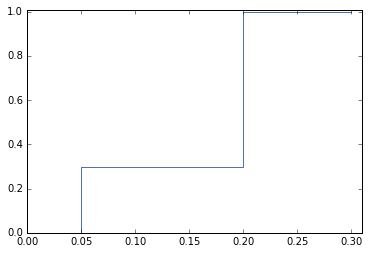

In [82]:
#CDF

plt.step([0.05,.2,.3],[0,.3,1])
plt.xlim(0,.31)
plt.ylim(0,1.01)


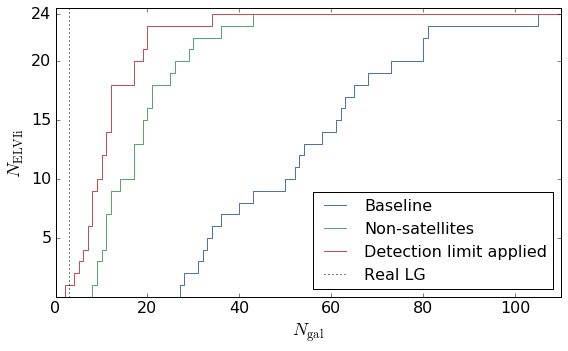

In [83]:
plt.figure(figsize=(8,5), facecolor='w')

toshow = ['raw_findable', 'nsat_findable', 'corr_findable']
ltoshow = [globals()[n] for n in toshow]
labels = {'raw_findable':'Baseline',
          'nsat_findable':'Non-satellites',
          'corr_findable':'Detection limit applied'}

xmax = np.max([np.max(l) for l in ltoshow]) + 5

for nm, lst in zip(toshow, ltoshow):
    plt.step(np.append(np.sort(lst), xmax), np.arange(len(lst)+1), label=labels[nm])
    
plt.axvline(3, ls=':', c='k', label='Real LG')

plt.legend(loc=0, fontsize=16)

plt.xlim(0, xmax)
plt.ylim(0, len(ltoshow[0])+.5)
plt.xticks(fontsize=16)
plt.yticks([5,10,15,20,24], fontsize=16)

plt.xlabel(r'$N_{\rm gal}$',fontsize=18)
plt.ylabel(r'$N_{\rm ELVIi}$',fontsize=18)

plt.tight_layout()

# McConn15 Fig5-like-plots 

<Column name='findable_dr1_host1' dtype='bool' length=5081>
False
False
False
False
False
False
False
False
False
False
False
False
  ...
False
False
False
False
False
False
False
False
False
False
False
False

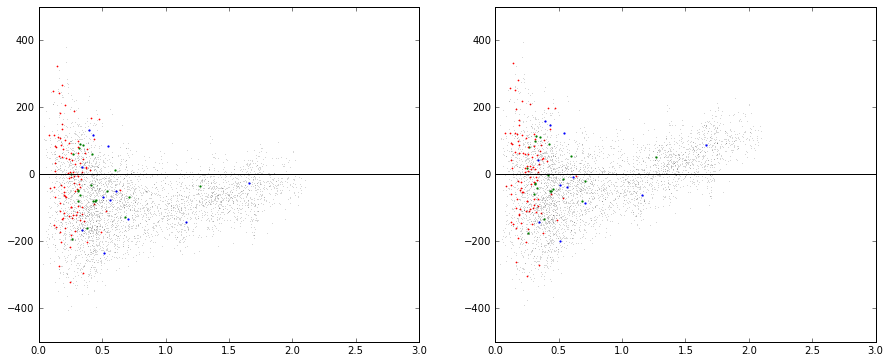

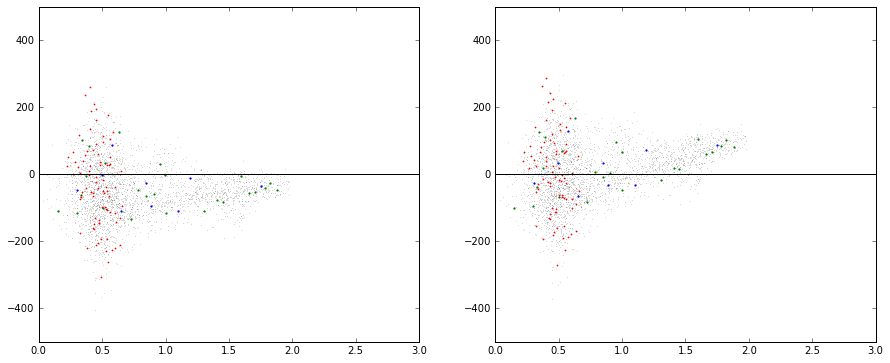

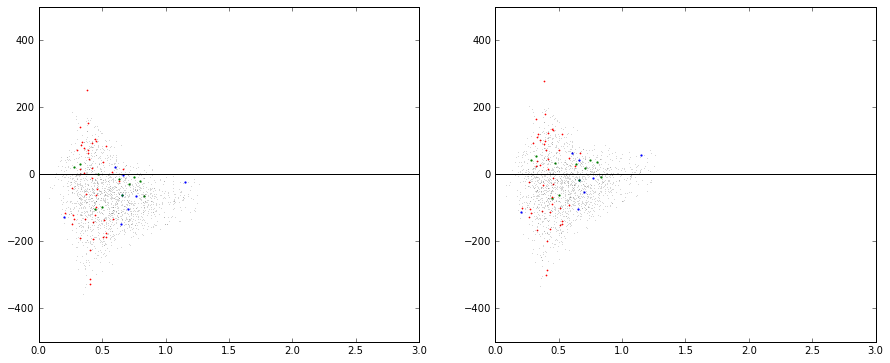

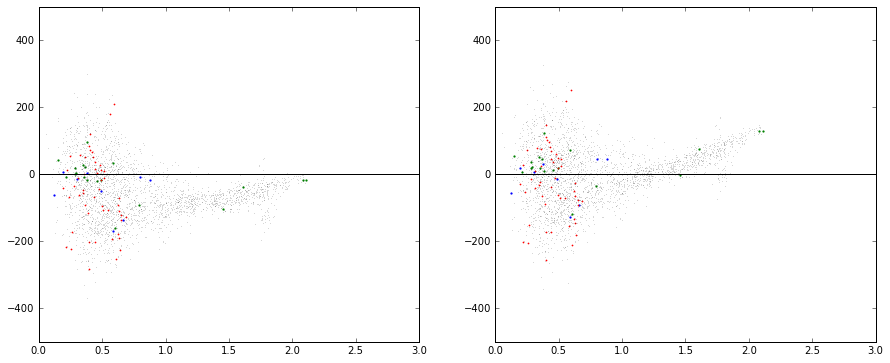

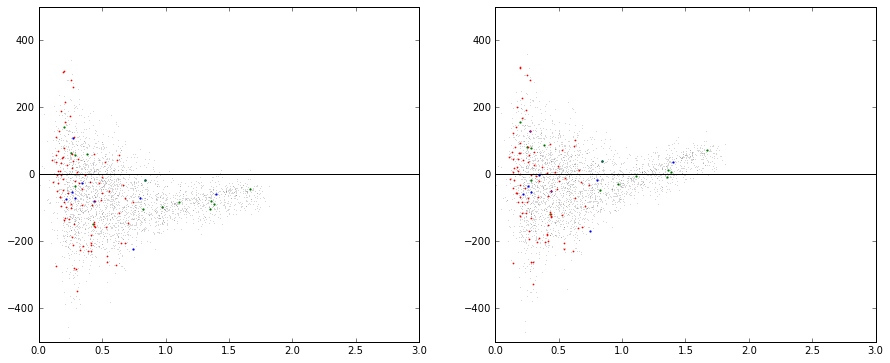

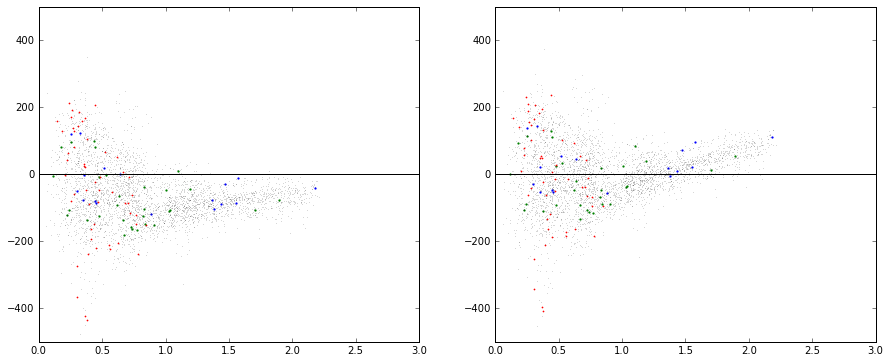

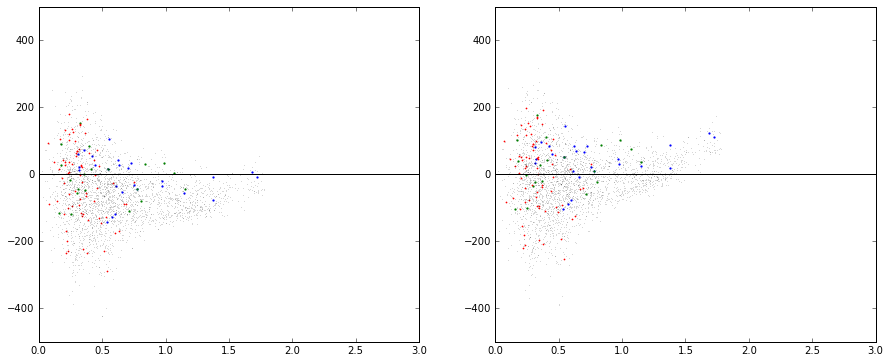

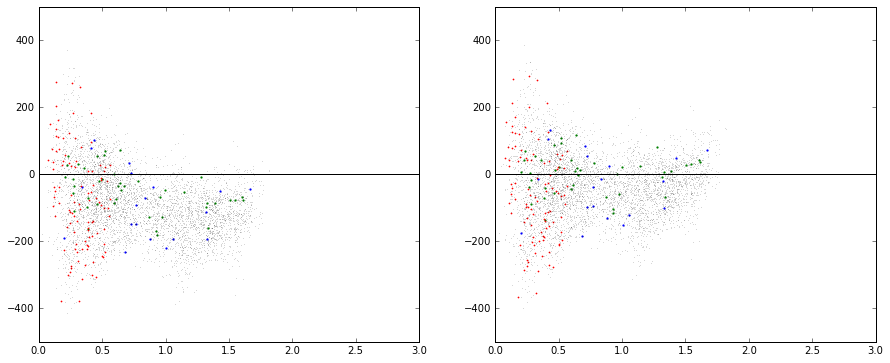

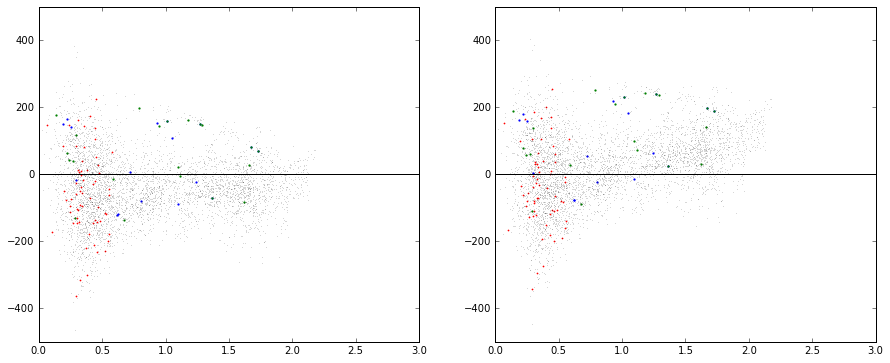

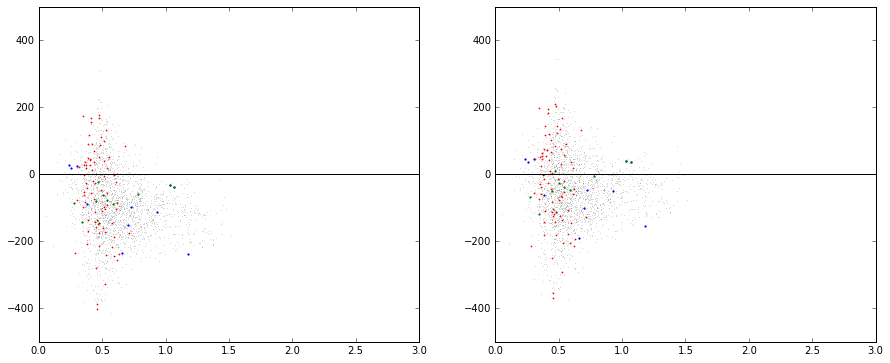

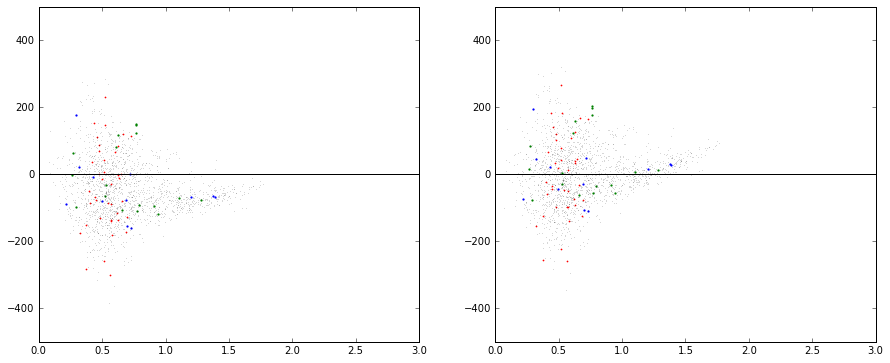

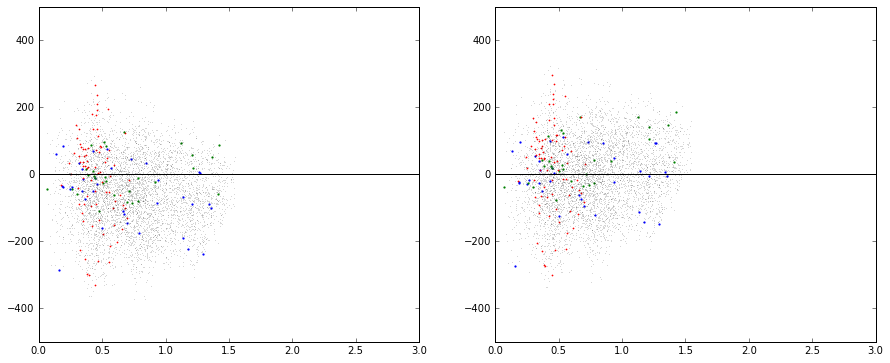

In [174]:
for name, tab in elvii_pairs.items():
    xyz = u.Quantity((tab['X'],tab['Y'],tab['Z']))
    vxyz = u.Quantity((tab['Vx'],tab['Vy'],tab['Vz']))
    Mtot = np.sum(tab['Mvir'][:2])
    com = np.sum(tab['Mvir'][:2]*xyz[:, :2],axis=-1)/np.sum(tab['Mvir'][:2])
    cov = np.sum(tab['Mvir'][:2]*vxyz[:, :2],axis=-1)/np.sum(tab['Mvir'][:2])
    dxyz = (xyz.T-com).T
    dvxyz = (vxyz.T-cov).T
    rhat = dxyz*np.sum(dxyz**2,axis=0)**-0.5
    
    dd = np.sum(dxyz**2, axis=0)**0.5
    v = np.sum(dvxyz*rhat, axis=0)
    vwhub = v+dd*cosmology.WMAP9.H0
    
    find0 = tab['findable_dr1_host0']
    find1 = tab['findable_dr1_host1']
    sat = tab['sat_of_either']
    #msks = [find0&find1, find0&~find1, ~find0&find1, ~find0&~find1]
    msks = [find0&~sat, find1&~sat,(find0|find1)&sat, ~find0&~find1]
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    for msk, c, s, a in zip(msks, 'bgrk', [5,5,3,1], [1,1,1,.2]):
        plt.scatter(dd[msk], v[msk], lw=0, s=s, alpha=a, c=c)
    plt.axhline(0, c='k')
    plt.xlim(0, 3)
    plt.ylim(-500, 500)
    
    plt.subplot(1,2,2)
    for msk, c, s, a in zip(msks, 'bgrk', [5,5,3,1], [1,1,1,.2]):
        plt.scatter(dd[msk], vwhub[msk], lw=0, s=s, alpha=a, c=c)
    plt.axhline(0, c='k')
    plt.xlim(0, 3)
    plt.ylim(-500, 500)